/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Coupling map:


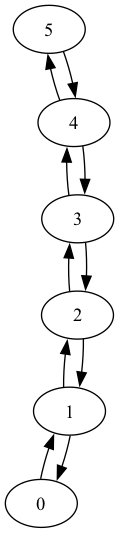

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt
from rl_qoc.helpers.transpiler_passes import CausalConePass

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

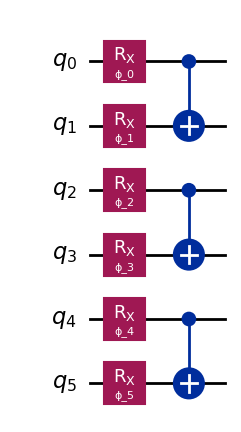

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


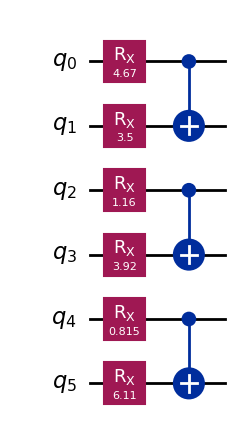

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

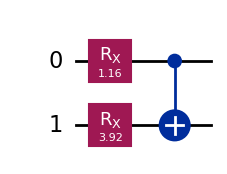

In [4]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

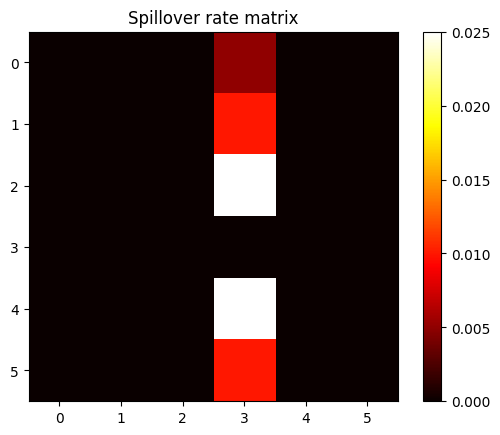

In [5]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.0  # γ_0->1
gamma_matrix[0, 3] = 0.005  # γ_0->3
gamma_matrix[1, 2] = 0.0  # γ_1->2
gamma_matrix[1, 3] = 0.01  # γ_1->3
gamma_matrix[2, 2] = 0.0  # γ_2->2
gamma_matrix[2, 3] = 0.025  # γ_2->3
gamma_matrix[3, 2] = 0.0  # γ_3->2
gamma_matrix[4, 3] = 0.025  # γ_4->3
gamma_matrix[5, 3] = 0.01  # γ_5->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
# gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)

# Generate another gamma matrix based on coupling map defined above
# gamma_matrix = 0.0 * np.eye(num_qubits)
# for edge in cm.get_edges():
#     gamma_matrix[edge[0], edge[1]] = 0.05


# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [6]:
gamma_matrix

array([[0.   , 0.   , 0.   , 0.005, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.01 , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.01 , 0.   , 0.   ]])

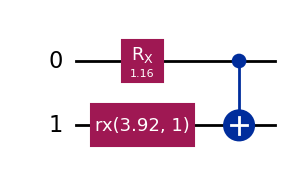

In [7]:
spillover_pass = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
causal_cone_pass = CausalConePass((2, 3))
pm = PassManager([spillover_pass, causal_cone_pass])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy = circuit.assign_parameters(param_dict)
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [8]:
qc_noisy.qubits

[Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)]

In [9]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[1.1607433119572852]), qubits=(Qubit(QuantumRegister(6, 'q'), 2),), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[-0.38160732+0.j        ,  0.        -0.92432454j],
       [ 0.        -0.92432454j, -0.38160732+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 3),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=())]

In [10]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [11]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '019bbc882b3d48e5b2e329e28fce2c41',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99644118+0.j        , 0.        -0.08429101j],
              [0.        -0.08429101j, 0.99644118+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [12]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager(
    [spillover_pass, causal_cone_pass] + full_pm.translation._tasks[0]
)
full_pm.translation = custom_translation_pass

In [13]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x15d666e90>,

In [14]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [15]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '019bbc882b3d48e5b2e329e28fce2c41',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99644118+0.j        , 0.        -0.08429101j],
              [0.        -0.08429101j, 0.99644118+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [16]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


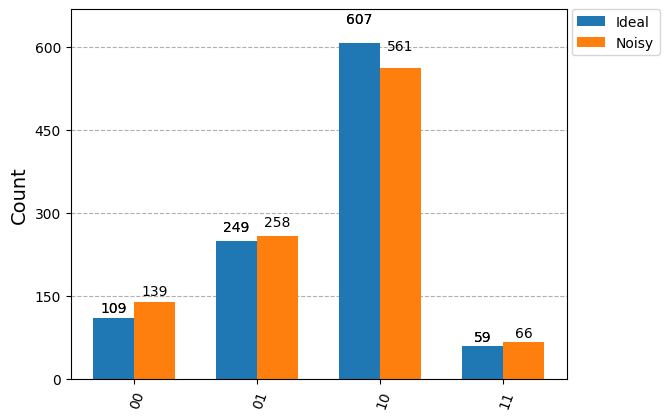

In [17]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [18]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [19]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9943160204742245

In [20]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


# def apply_parametrized_circuit(
#     qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
# ):
#     """
#     Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
#     This function is used to run the QuantumCircuit instance on a Runtime backend
#     :param qc: Quantum Circuit instance to add the gate on
#     :param params: Parameters of the custom Gate
#     :param q_reg: Quantum Register formed of target qubits
#     :return:
#     """
#     target = kwargs["target"]
#     my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
#     optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
#     # optimal_params = np.pi * np.zeros(len(params))
#     new_params = [optimal_params[i] + params[i] for i in range(len(params))]

#     my_qc.u(
#         new_params[0],
#         -np.pi/2,
#         np.pi/2,
#         q_reg[0],
#     )
#     my_qc.u(
#         0.,
#         new_params[1],
#         new_params[2],
#         q_reg[0],
#     )
#     my_qc.u(
#         *new_params[3:6],
#         q_reg[1],
#     )

#     my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

#     qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [134]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-0.20, high=0.20, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[20,],
        n_shots=100,
        sampling_paulis=1000,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

In [22]:
from general_angle_spillover_env import GeneralAngleSpilloverEnv

general_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[2, 4],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [[-1.  -1. ]
 [-1.  -0.5]
 [-1.   0. ]
 [-1.   0.5]
 [-1.   1. ]
 [-0.5 -1. ]
 [-0.5 -0.5]
 [-0.5  0. ]
 [-0.5  0.5]
 [-0.5  1. ]
 [ 0.  -1. ]
 [ 0.  -0.5]
 [ 0.   0. ]
 [ 0.   0.5]
 [ 0.   1. ]
 [ 0.5 -1. ]
 [ 0.5 -0.5]
 [ 0.5  0. ]
 [ 0.5  0.5]
 [ 0.5  1. ]
 [ 1.  -1. ]
 [ 1.  -0.5]
 [ 1.   0. ]
 [ 1.   0.5]
 [ 1.   1. ]]
Observation Vals for Env: [[0.         0.        ]
 [0.         0.78539816]
 [0.         1.57079633]
 [0.         2.35619449]
 [0.         3.14159265]
 [0.78539816 0.        ]
 [0.78539816 0.78539816]
 [0.78539816 1.57079633]
 [0.78539816 2.35619449]
 [0.78539816 3.14159265]
 [1.57079633 0.        ]
 [1.57079633 0.78539816]
 [1.57079633 1.57079633]
 [1.57079633 2.35619449]
 [1.57079633 3.14159265]
 [2.35619449 0.        ]
 [2.35619449 0.78539816]
 [2.35619449 1.57079633]
 [2.35619449 2.35619449]
 [2.35619449 3.14159265]
 [3.14159265 0.        ]
 [3.14159265 0.78539816]
 [3.14159265 1.57079633]
 [3.14159265 2.35619449]
 [3.14159265 3.14159

In [23]:
rescaled_general_env = RescaleAndClipAction(general_env, min_action=-1., max_action=1.)

In [128]:
_, _ = general_env.reset(
    debug_obs=np.array([np.pi, np.pi])
)

Sampled angles:  [0.         0.         3.14159265 0.         3.14159265 0.        ]
Environment Observation: [1. 1.]


In [129]:
print(general_env.observation_space.shape[0])

2


In [130]:
print(gamma_matrix.T)

[[0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.005 0.01  0.025 0.    0.025 0.01 ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]]


In [131]:
computed_spillover_angles = general_env.gamma_matrix.T @ general_env.phi_vec
subsystem_spillover_angles = computed_spillover_angles[[2, 3]]
subsystem_spillover_angles / np.pi

opt_action = np.zeros((1, 7))
opt_action[0, [2,3]] = -subsystem_spillover_angles

In [132]:
opt_action

array([[ 0.        ,  0.        , -0.        , -0.15707963,  0.        ,
         0.        ,  0.        ]])

Number of repetitions: 1
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.9950753362380551 Std: 0.0
Number of repetitions: 3
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.9564026096753473 Std: 0.0
Number of repetitions: 5
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.8828427124746192 Std: 0.0
Number of repetitions: 7
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.7815961998958193 Std: 0.0
Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.6625737860160934 Std: 0.0
Number of repetitions: 11
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity 

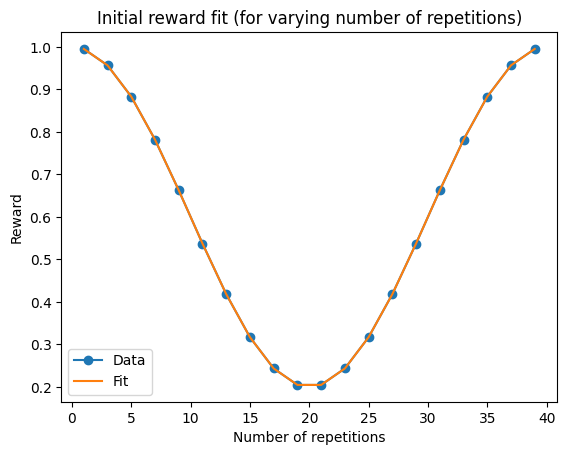

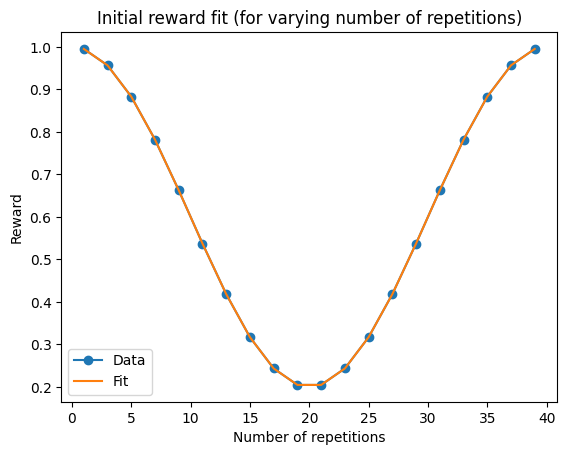

In [133]:
general_env.initial_reward_fit(
    np.zeros((1, 7)),
    # opt_action,
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 40, 2),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method="fidelity",
    fit_p0=list(subsystem_spillover_angles)
)

In [30]:
# PPO Details

from ppo_cleanrl import PPO_CleanRL

train_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[2, 4],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 300,
    "learning_rate": 3e-3,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 1600,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.0,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

# alt_q_env.clear_history()
rescaled_q_env = RescaleAndClipAction(train_env, min_action=-1., max_action=1.)
ppo_agent = PPO_CleanRL(agent_config, rescaled_q_env)

Observation Vals for Agent: [[-1.  -1. ]
 [-1.  -0.5]
 [-1.   0. ]
 [-1.   0.5]
 [-1.   1. ]
 [-0.5 -1. ]
 [-0.5 -0.5]
 [-0.5  0. ]
 [-0.5  0.5]
 [-0.5  1. ]
 [ 0.  -1. ]
 [ 0.  -0.5]
 [ 0.   0. ]
 [ 0.   0.5]
 [ 0.   1. ]
 [ 0.5 -1. ]
 [ 0.5 -0.5]
 [ 0.5  0. ]
 [ 0.5  0.5]
 [ 0.5  1. ]
 [ 1.  -1. ]
 [ 1.  -0.5]
 [ 1.   0. ]
 [ 1.   0.5]
 [ 1.   1. ]]
Observation Vals for Env: [[0.         0.        ]
 [0.         0.78539816]
 [0.         1.57079633]
 [0.         2.35619449]
 [0.         3.14159265]
 [0.78539816 0.        ]
 [0.78539816 0.78539816]
 [0.78539816 1.57079633]
 [0.78539816 2.35619449]
 [0.78539816 3.14159265]
 [1.57079633 0.        ]
 [1.57079633 0.78539816]
 [1.57079633 1.57079633]
 [1.57079633 2.35619449]
 [1.57079633 3.14159265]
 [2.35619449 0.        ]
 [2.35619449 0.78539816]
 [2.35619449 1.57079633]
 [2.35619449 2.35619449]
 [2.35619449 3.14159265]
 [3.14159265 0.        ]
 [3.14159265 0.78539816]
 [3.14159265 1.57079633]
 [3.14159265 2.35619449]
 [3.14159265 3.14159

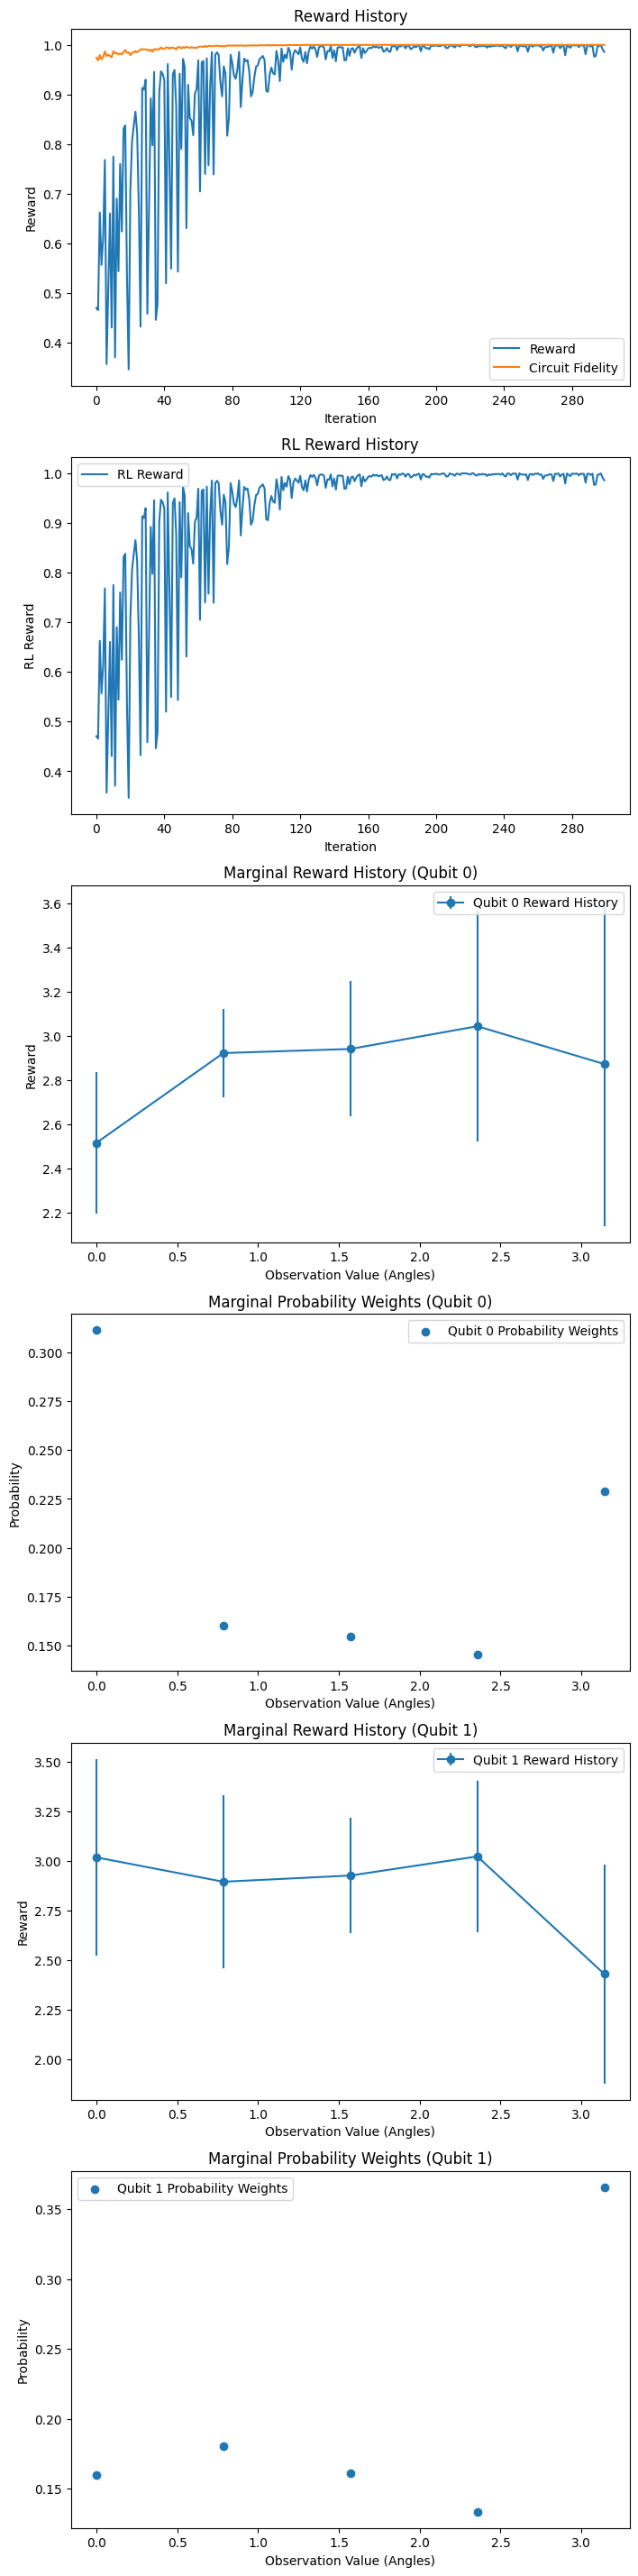

model saved to runs/PPO_CleanRL__Test PPO CleanRL__1__1747351093/Test PPO CleanRL.cleanrl_model


In [31]:
# from gymnasium.wrappers import ActionWrapper

ppo_agent.env.unwrapped.clear_history()
# ppo_agent.env.clear_history()
ppo_agent.run_training()

In [32]:
NUM_EVAL = 25
import torch

action_list = []
obs_list = []
reward_list = []

for n in range(NUM_EVAL):
    obs, _ = ppo_agent.env.reset()
    obs_list.append(obs)
    batch_obs = np.tile(obs, (32, 1))
    with torch.no_grad():
        batch_action, logprob, _, value = ppo_agent.agent.get_action_and_value(
            torch.Tensor(batch_obs)
        )
    next_obs, reward, terminations, truncations, infos = ppo_agent.env.step(
        batch_action.numpy()
    )
    reward_list.append(np.mean(reward))
    mean_action = np.mean(batch_action.numpy(), axis=0)
    action_list.append(mean_action)

Sampled angles:  [0.         0.         2.35619449 0.         2.35619449 0.        ]
Environment Observation: [0.5 0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999331334646083
Reward (avg): 0.9954280615314356 Std: 0.0007487735315117124
obs: [0.5 0.5]
reward: [2.40828776 2.37019221 2.37541363 2.30818315 2.34069966 2.46969577
 2.42503622 2.27394322 2.26966877 2.28707214 2.31638277 2.3668982
 2.30937162 2.37547793 2.35101686 2.3046957  2.38913573 2.52289567
 2.33558163 2.30096176 2.23294354 2.36277567 2.25647463 2.4318226
 2.39687873 2.30324441 2.31778765 2.18991068 2.42837538 2.37445924
 2.24743669 2.42165011]
Sampled angles:  [0.         0.         3.14159265 0.         3.14159265 0.        ]
Environment Observation: [1. 1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9997038934545635
Reward (avg): 0.9735551693529395 Std: 0.0018276454015405514
obs: [1. 1.]
reward: [1.60836539 1.61047046 1.60784519 1.59892497 1.57057419 1.59246207
 1.573103   1.56365062 1.58262635 1.56773077 1.61432768 1.60690511
 1.63746144 1.59568201 1.5386813  1.56350312 1.56393708 1.55999841
 1.5311651  1.50741852 1.57947327 1.60571806 1.62101374 1.54228423
 1.53896016 1.55743836 1.62630755 1.55020411 1.5714724  1.58646558
 1.5737386  1.57011406]
Sampled angles:  [0.         0.         0.78539816 0.         1.57079633 0.        ]
Environment Observation: [-0.5  0. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999967912546615
Reward (avg): 0.998019547572647 Std: 0.0006345291173477333
obs: [-0.5  0. ]
reward: [2.76340095 2.78213821 2.62973287 2.57408261 2.83954122 2.91971096
 2.64232592 2.71508042 3.1262117  2.68650494 2.72645787 2.82619676
 2.68523682 2.71863113 2.46543876 2.75365023 2.69270118 2.65283907
 2.848894   2.61517537 2.89043577 2.45854796 2.93478574 2.77226336
 2.79925844 2.8152225  2.67400421 2.75370615 2.51039972 2.51135195
 2.80226224 2.63161463]
Sampled angles:  [0.         0.         0.78539816 0.         0.         0.        ]
Environment Observation: [-0.5 -1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998959196893895
Reward (avg): 0.9911753039695145 Std: 0.0009464197773948724
obs: [-0.5 -1. ]
reward: [2.13289848 2.04472228 2.10907962 2.07211942 2.01584441 2.00318581
 1.96396689 2.11220368 2.12126357 2.09814462 2.02007095 2.08050767
 2.0893548  2.07447429 2.04255837 1.93940814 2.11039146 2.00856531
 2.03347243 2.03838239 2.01744353 2.0628733  2.0191446  2.11679561
 2.07587714 2.05297981 2.0737274  2.02784781 2.07158979 2.01718567
 2.07900738 2.08954677]
Sampled angles:  [0.         0.         0.         0.         3.14159265 0.        ]
Environment Observation: [-1.  1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999818090508885
Reward (avg): 0.9986042536493042 Std: 0.0006750916105753641
obs: [-1.  1.]
reward: [2.91360252 3.32941431 3.06284905 3.1169217  2.68423601 2.48108128
 2.91782567 2.84164337 3.02587355 3.41542556 2.83961015 2.88637871
 3.06802346 2.75838864 2.72218616 3.14179441 2.94595315 2.76539028
 2.92234965 2.69668962 2.69766272 2.91859874 2.58053367 2.68583269
 3.06104695 3.05685669 2.6505317  3.21179552 2.75910062 2.68874217
 3.49582495 2.8611769 ]
Sampled angles:  [0.         0.         3.14159265 0.         3.14159265 0.        ]
Environment Observation: [1. 1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9997016360947264
Reward (avg): 0.9733410911691789 Std: 0.001624705194632407
obs: [1. 1.]
reward: [1.58745115 1.58082439 1.57234778 1.61085193 1.55215554 1.52628372
 1.60187552 1.53798835 1.57608854 1.59467639 1.55625004 1.53171562
 1.57183895 1.54583462 1.5795966  1.55319797 1.54868534 1.55714598
 1.60529931 1.53625036 1.57316476 1.57461217 1.60011467 1.62728708
 1.58011033 1.61568009 1.588508   1.53624633 1.59672987 1.60343189
 1.59210497 1.58438162]
Sampled angles:  [0.         0.         1.57079633 0.         0.78539816 0.        ]
Environment Observation: [ 0.  -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999730119755728
Reward (avg): 0.9985585321725364 Std: 0.0004414960680029668
obs: [ 0.  -0.5]
reward: [2.82333401 2.94416332 2.79796659 2.78765101 2.90080883 3.10581693
 2.8778339  2.79156072 2.66505835 2.83018884 2.80699926 2.79093858
 3.04068036 2.95654201 2.85370132 2.85063359 2.87414716 2.71141643
 2.90239491 2.76491657 2.97044336 3.05758361 2.83103777 2.90829247
 3.1577502  2.72255579 2.74714651 2.96075354 2.83813338 2.6501662
 3.08638078 2.5610175 ]
Sampled angles:  [0.         0.         0.         0.         0.78539816 0.        ]
Environment Observation: [-1.  -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999883334694814
Reward (avg): 0.9894030292741431 Std: 0.0016684803457739281
obs: [-1.  -0.5]
reward: [1.92133752 1.84989055 2.00517036 1.9673537  1.91163098 1.98557131
 2.05113879 2.03702987 2.07382234 1.97887735 1.95957092 2.06042253
 1.97344325 1.9935031  2.110372   1.90964007 1.9578714  2.00129241
 1.98027528 1.94235022 1.92907144 1.88178893 1.9965412  2.12908463
 1.95092926 1.9932094  1.99694456 1.90333738 2.05381959 1.97840353
 2.04944285 1.83185694]
Sampled angles:  [0.         0.         0.         0.         0.78539816 0.        ]
Environment Observation: [-1.  -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998822614601833
Reward (avg): 0.9892622979642485 Std: 0.0012518788032469712
obs: [-1.  -0.5]
reward: [1.94937263 2.06538753 1.98842783 2.01336034 1.96635091 1.97747391
 2.03993919 1.89857333 1.96151969 2.03624248 1.87400051 2.03301245
 1.96918331 1.96433678 1.9742775  1.96328952 2.00394218 1.98966153
 1.9211525  1.93189996 1.95626319 2.05544396 1.95639464 1.96265519
 1.93776049 2.03450651 1.97428071 1.9484119  1.97190161 1.9702179
 1.83298438 1.97894298]
Sampled angles:  [0.         0.         3.14159265 0.         3.14159265 0.        ]
Environment Observation: [1. 1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9997035268850233
Reward (avg): 0.9735029936238679 Std: 0.001682129136639418
obs: [1. 1.]
reward: [1.60107739 1.55191858 1.59165226 1.5878543  1.62361071 1.61262162
 1.62513226 1.5177681  1.55759476 1.57641403 1.58689509 1.55222346
 1.54981394 1.57893429 1.62409291 1.58496778 1.52130855 1.55221313
 1.59722267 1.56771412 1.58316498 1.6093562  1.58361257 1.58923362
 1.55138768 1.53765722 1.57761689 1.58434792 1.56342373 1.57677288
 1.60693021 1.56090532]
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1. -1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998129622282093
Reward (avg): 0.9824329982572297 Std: 0.0014859628503611176
obs: [-1. -1.]
reward: [1.74829889 1.73787231 1.76821175 1.77231238 1.74254413 1.76727626
 1.74295835 1.80284115 1.78581113 1.76317857 1.72848336 1.78482904
 1.76943377 1.75590384 1.66603945 1.68119038 1.75761632 1.76901175
 1.80447302 1.74983062 1.70489107 1.71370601 1.80068255 1.75677381
 1.74818596 1.78640929 1.77075922 1.71439621 1.84536367 1.74324172
 1.73724237 1.79869073]
Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [ 1. -1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999832646430797
Reward (avg): 0.9999132328232845 Std: 7.203439307622746e-05
obs: [ 1. -1.]
reward: [4.25377655 4.65035786 4.38335238 3.77018138 4.50713137 4.00816963
 4.70035957 3.78997815 4.70686571 4.38462943 4.32991359 3.84371699
 3.60738934 3.7637872  4.1170221  5.0103533  3.68364013 3.50777804
 4.36151203 4.35818246 4.12458093 4.26742341 4.53595469 4.36475716
 4.46940971 4.07251487 3.97564125 4.03480682 4.15217413 3.80927016
 4.38317427 4.53008995]
Sampled angles:  [0.         0.         3.14159265 0.         3.14159265 0.        ]
Environment Observation: [1. 1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9997100196882334
Reward (avg): 0.9741139077293739 Std: 0.001724938778098056
obs: [1. 1.]
reward: [1.57240404 1.61296841 1.60036247 1.59252271 1.56630995 1.61685332
 1.54905827 1.60288481 1.54304758 1.59106811 1.57211622 1.55736417
 1.62127947 1.60482406 1.55192241 1.62772003 1.56807907 1.56778918
 1.61378955 1.56751772 1.5496427  1.64446725 1.60257404 1.55866924
 1.5487813  1.59427997 1.63735743 1.54823256 1.59546198 1.62653372
 1.5936697  1.61332626]
Sampled angles:  [0.         0.         0.78539816 0.         3.14159265 0.        ]
Environment Observation: [-0.5  1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999733088205366
Reward (avg): 0.9986966586313577 Std: 0.0006958317131185999
obs: [-0.5  1. ]
reward: [2.80824891 2.69387076 2.61671928 2.89367527 3.05705126 2.76418871
 2.9261498  3.13370732 2.72526875 2.51646189 2.75864478 3.5908846
 2.8229866  2.93748109 2.54736377 3.3374433  3.10041734 3.15073758
 3.10722597 2.67771932 2.82054564 2.6760244  2.88291905 3.04123391
 3.1449792  3.35118154 2.83433507 3.15313894 2.82280584 3.16972485
 3.34597328 3.06841154]
Sampled angles:  [0.         0.         1.57079633 0.         0.         0.        ]
Environment Observation: [ 0. -1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999434051145281
Reward (avg): 0.9960435413962219 Std: 0.0006436567516052179
obs: [ 0. -1.]
reward: [2.33372949 2.44015243 2.33297664 2.39166562 2.31513239 2.37390798
 2.36892955 2.36369929 2.4672899  2.40252376 2.29782074 2.43678463
 2.49513729 2.39503266 2.48410022 2.46112517 2.42586217 2.46226671
 2.41420369 2.38035239 2.41650981 2.44563751 2.32812382 2.32805883
 2.57122123 2.47052607 2.46306588 2.6137183  2.41456749 2.28274259
 2.33675864 2.36732799]
Sampled angles:  [0.         0.         0.         0.         1.57079633 0.        ]
Environment Observation: [-1.  0.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999378110735981
Reward (avg): 0.9943357033105913 Std: 0.0009324220251483225
obs: [-1.  0.]
reward: [2.19045194 2.24543109 2.23271838 2.32154763 2.18913643 2.36603794
 2.2201096  2.18004147 2.15114147 2.27994669 2.35607799 2.14722841
 2.25477183 2.25557187 2.29162411 2.20362991 2.2084798  2.29767804
 2.20754636 2.37948587 2.30192731 2.22392384 2.39378398 2.25340694
 2.35336066 2.30002799 2.24322286 2.27049823 2.29055485 2.12307934
 2.24193153 2.11368532]
Sampled angles:  [0.         0.         1.57079633 0.         0.78539816 0.        ]
Environment Observation: [ 0.  -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999681678026457
Reward (avg): 0.9984224002414048 Std: 0.00031374920074121206
obs: [ 0.  -0.5]
reward: [2.73990186 2.75646237 2.96317622 2.74955866 2.75047534 2.84964464
 2.88017812 2.67221518 2.92803841 2.8200593  2.85338751 2.57249764
 2.91185029 2.8100064  2.80264389 2.72679143 2.7088038  2.82994739
 2.78401134 2.90060658 2.83843463 2.78696356 2.79618431 2.86962804
 2.82883407 2.90252923 2.93444381 2.79242723 2.78449056 2.85223468
 2.78688485 2.73262254]
Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [ 1. -1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999797673820442
Reward (avg): 0.9998988851358555 Std: 8.73683880000491e-05
obs: [ 1. -1.]
reward: [4.43528707 4.17670831 4.39603874 3.84053302 4.58950487 4.08201329
 4.20752618 4.09958272 4.04622537 3.61656059 3.78175687 4.39779608
 3.51960174 4.08654149 4.27312566 4.28909981 3.55317784 4.09068277
 4.36107776 4.04873459 3.96124555 3.53048669 4.28861947 4.51860534
 3.49744002 4.22933131 4.01471198 4.09208353 4.1426661  6.
 4.22498363 5.25181225]
Sampled angles:  [0.         0.         3.14159265 0.         3.14159265 0.        ]
Environment Observation: [1. 1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999703739082418
Reward (avg): 0.9733822313881977 Std: 0.0014227675043613352
obs: [1. 1.]
reward: [1.56683213 1.58508737 1.57663465 1.55555051 1.58399558 1.62370641
 1.60524576 1.57411717 1.55067309 1.54558055 1.57106957 1.57120223
 1.55739288 1.54102874 1.58801903 1.58096972 1.58774494 1.56011342
 1.62338048 1.57629892 1.58514603 1.57975075 1.5507734  1.61819288
 1.56184096 1.5278849  1.55518757 1.60856472 1.55592765 1.58857251
 1.59750757 1.56059325]
Sampled angles:  [0.         0.         3.14159265 0.         1.57079633 0.        ]
Environment Observation: [1. 0.]


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999371118973905
Reward (avg): 0.9956286565778203 Std: 0.0005076701141968506
obs: [1. 0.]
reward: [2.42562043 2.3509441  2.33568881 2.45268622 2.40185032 2.31781856
 2.4155837  2.39594901 2.29320278 2.38819183 2.3553397  2.3792773
 2.40092277 2.38632335 2.39565222 2.34427761 2.43054664 2.35868628
 2.29613536 2.30286382 2.37899485 2.3942499  2.34964795 2.30469188
 2.37980311 2.39407724 2.32310596 2.33194506 2.2907803  2.28606229
 2.2679157  2.46507783]
Sampled angles:  [0.         0.         0.         0.         3.14159265 0.        ]
Environment Observation: [-1.  1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999811132070406
Reward (avg): 0.9985815704783719 Std: 0.0008224170343073336
obs: [-1.  1.]
reward: [2.77401706 3.07107849 2.84059304 2.66578401 3.02710845 3.21942107
 2.88776008 2.9322962  2.564887   3.15167226 2.59978358 2.74742091
 3.09909466 3.17553692 2.67530913 2.77480449 3.14221982 3.40373384
 2.89859793 2.40939734 2.84561967 2.8599869  3.21452464 2.57025206
 3.21030453 3.10476094 2.73030397 2.87405467 3.5695093  2.58416909
 3.19700408 2.75130356]
Sampled angles:  [0.         0.         3.14159265 0.         3.14159265 0.        ]
Environment Observation: [1. 1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9996991967768856
Reward (avg): 0.9732445018183047 Std: 0.0015062332966692623
obs: [1. 1.]
reward: [1.59208066 1.58652329 1.61211212 1.56306792 1.619244   1.57755807
 1.54638722 1.53989331 1.53271976 1.57741794 1.57673594 1.55814704
 1.56792138 1.54630041 1.54822865 1.62389168 1.57227608 1.61456781
 1.59673925 1.57895135 1.5540945  1.5743301  1.54972686 1.56460427
 1.54612104 1.53551327 1.57844207 1.59404757 1.59895888 1.55362482
 1.5684388  1.59639676]
Sampled angles:  [0.         0.         3.14159265 0.         3.14159265 0.        ]
Environment Observation: [1. 1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9997098447977755
Reward (avg): 0.9740388969704603 Std: 0.0014773681711621922
obs: [1. 1.]
reward: [1.6048587  1.53963609 1.56479571 1.58355072 1.61161817 1.56562025
 1.61656844 1.57768471 1.57955027 1.62190026 1.54467503 1.58190998
 1.62416027 1.59052518 1.62019876 1.60232691 1.58804796 1.58307871
 1.57756612 1.57181445 1.59209248 1.54318986 1.59324419 1.60749416
 1.61265331 1.53960646 1.58580731 1.59355863 1.59933572 1.56179295
 1.56268163 1.62236185]
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1. -1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998111480846096
Reward (avg): 0.9824392766630377 Std: 0.001651948928315837
obs: [-1. -1.]
reward: [1.76610739 1.76013486 1.73732773 1.77208173 1.73473283 1.69656914
 1.72646529 1.7223487  1.82955493 1.76387443 1.76227839 1.78959452
 1.74023258 1.79622562 1.78675985 1.80707648 1.73504199 1.73685018
 1.76872899 1.82244374 1.71655231 1.82185896 1.7493554  1.64935842
 1.69355159 1.81836705 1.72388198 1.77556806 1.76540023 1.73543463
 1.78202454 1.74905902]
Sampled angles:  [0.         0.         2.35619449 0.         3.14159265 0.        ]
Environment Observation: [0.5 1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998565191680783
Reward (avg): 0.9877423087012048 Std: 0.0009243728575600178
obs: [0.5 1. ]
reward: [1.91936616 1.89092389 1.89973919 1.8440147  1.86155237 1.92983797
 1.91257211 1.90130355 1.90125502 1.95418222 1.95473668 1.86538068
 1.94345254 1.83887329 1.91617794 1.87694496 1.90060267 1.93567007
 1.97825628 1.92016016 1.92417276 1.94254925 1.90196628 1.89466216
 1.90896178 1.91823731 1.96723384 1.93125259 1.91470368 1.89394571
 1.91957638 1.9474719 ]


/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_18833/4258992135.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


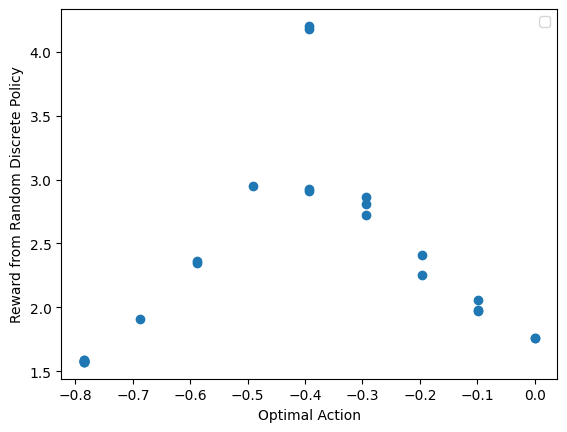

In [33]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[2, 4], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1) / 0.2

plt.scatter(optimal_action, reward_list)
plt.xlabel('Optimal Action')
plt.ylabel('Reward from Random Discrete Policy')
plt.legend()
plt.show()

In [34]:
df_hist = ppo_agent.env.unwrapped.discrete_reward_history

print(df_hist.shape)

(3, 25)


In [35]:
print(df_hist)

[[1.7573388  1.97191148 2.25275186 3.15587515 2.92413468 2.05670729
  2.99330448 2.72555636 3.29029454 2.95242249 2.40877971 2.80987293
  2.82297819 2.65755401 2.44603538 3.66684512 3.6850553  2.96291561
  2.34576155 1.91280425 4.17636127 3.5880949  2.36230978 3.81611874
  1.58637204]
 [1.75682685 1.98015605 2.84861222 3.05979613 2.91260439 2.84567671
  2.99090632 2.89856089 3.17374497 3.04282298 2.86657477 2.86150043
  3.15734441 2.90045354 3.4795073  3.53163322 2.62977615 3.50428255
  3.0335961  1.84891023 4.2018092  2.70175844 2.60510387 3.53633717
  1.57328321]
 [2.18478739 2.0518028  2.61798473 2.67064734 2.55314935 3.08569714
  2.73869829 3.18025666 2.60267892 2.70503407 2.32764956 3.20752591
  2.93016378 3.30163978 2.93980178 3.44821552 3.48130585 2.78647682
  3.21887076 2.38408506 3.30691552 2.65726597 3.5142169  2.47795421
  1.57545579]]


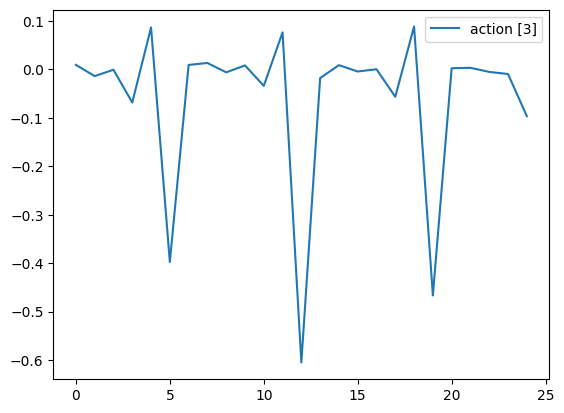

In [36]:
action_arr = np.array(action_list)
action_arr = action_arr.reshape(7, -1)

for i in range(len(action_arr)):
    if i == 3:
        plt.plot(action_arr[i], label=f'action [{i}]')
plt.legend()
plt.show()

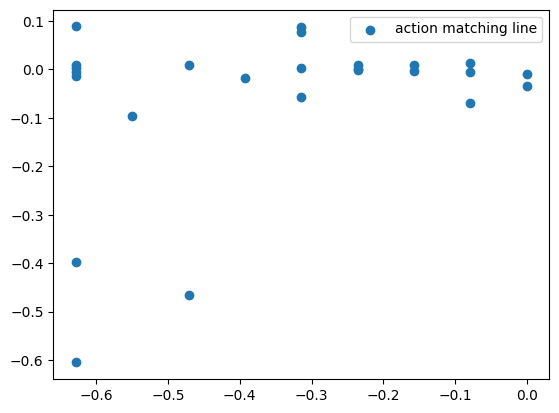

In [37]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[2, 4], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1) / 0.25

action_relevant = action_arr[3]

plt.scatter(optimal_action, np.clip(action_relevant, a_min=-1., a_max=1.), label='action matching line')
plt.legend()
plt.show()

In [38]:
single_n_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=4,
        n_reps=[1,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

single_n_q_env = GeneralAngleSpilloverEnv(
    single_n_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[2, 4],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [[-1.  -1. ]
 [-1.  -0.5]
 [-1.   0. ]
 [-1.   0.5]
 [-1.   1. ]
 [-0.5 -1. ]
 [-0.5 -0.5]
 [-0.5  0. ]
 [-0.5  0.5]
 [-0.5  1. ]
 [ 0.  -1. ]
 [ 0.  -0.5]
 [ 0.   0. ]
 [ 0.   0.5]
 [ 0.   1. ]
 [ 0.5 -1. ]
 [ 0.5 -0.5]
 [ 0.5  0. ]
 [ 0.5  0.5]
 [ 0.5  1. ]
 [ 1.  -1. ]
 [ 1.  -0.5]
 [ 1.   0. ]
 [ 1.   0.5]
 [ 1.   1. ]]
Observation Vals for Env: [[0.         0.        ]
 [0.         0.78539816]
 [0.         1.57079633]
 [0.         2.35619449]
 [0.         3.14159265]
 [0.78539816 0.        ]
 [0.78539816 0.78539816]
 [0.78539816 1.57079633]
 [0.78539816 2.35619449]
 [0.78539816 3.14159265]
 [1.57079633 0.        ]
 [1.57079633 0.78539816]
 [1.57079633 1.57079633]
 [1.57079633 2.35619449]
 [1.57079633 3.14159265]
 [2.35619449 0.        ]
 [2.35619449 0.78539816]
 [2.35619449 1.57079633]
 [2.35619449 2.35619449]
 [2.35619449 3.14159265]
 [3.14159265 0.        ]
 [3.14159265 0.78539816]
 [3.14159265 1.57079633]
 [3.14159265 2.35619449]
 [3.14159265 3.14159

In [39]:
# Visualizing Policy wrt actions

import torch

full_actions = []
actions = []
std_actions = []

for sample_obs in ppo_agent.env.unwrapped.discrete_obs_vals_raw:
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        -1,
        1.
        # ppo_agent.env.action_space.low,
        # ppo_agent.env.action_space.high,
    )
    cpu_action *= 0.2
    full_actions.append(cpu_action)
    actions.append(np.mean(cpu_action, axis=0))
    std_actions.append(np.std(cpu_action, axis=0))

In [40]:
o_vals = ppo_agent.env.unwrapped.discrete_obs_vals_angles

In [44]:
ana_sum = -np.sum(o_vals, axis=1) * 0.02
ana_sum

array([-0.        , -0.01570796, -0.03141593, -0.04712389, -0.06283185,
       -0.01570796, -0.03141593, -0.04712389, -0.06283185, -0.07853982,
       -0.03141593, -0.04712389, -0.06283185, -0.07853982, -0.09424778,
       -0.04712389, -0.06283185, -0.07853982, -0.09424778, -0.10995574,
       -0.06283185, -0.07853982, -0.09424778, -0.10995574, -0.12566371])

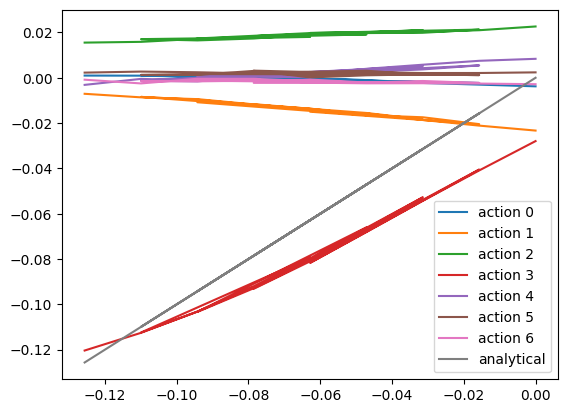

In [45]:
actions = np.array(actions)

for i in range(len(actions[0])):
    plt.plot(ana_sum, actions[:,i], label=f'action {i}')
# plt.plot(o_vals, (actions[:,1] - actions[:,2]) * np.pi, label=f'sum')
plt.plot(ana_sum, ana_sum, label=f'analytical')
plt.legend()
plt.show()

## Testing New PPO Algo

In [30]:
import uuid
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from gymnasium.spaces import Box
from typing import Dict, Optional, Any
import collections

# Adapted from CleanRL ppo_continuous_action.py
from rl_qoc.environment.base_q_env import BaseQuantumEnvironment

def process_action(self, probs: Normal):
    """
    Decide how actions should be processed before being sent to environment.
    For certain environments such as QUA, policy parameters should be streamed to the environment directly
    and actions are sampled within the environment (in real time).
    """
    action = probs.sample()
    logprob = probs.log_prob(action).sum(1)
    mean_action = probs.mean
    std_action = probs.stddev

    if isinstance(self.env, ActionWrapper):
        self.unwrapped_env.mean_action = self.env.action(mean_action[0].cpu().numpy())
    else:
        self.unwrapped_env.mean_action = mean_action[0].cpu().numpy()

    self.unwrapped_env.std_action = std_action[0].cpu().numpy()
    return action, logprob

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

def plot_curves(env: BaseQuantumEnvironment):
    """
    Plots the reward history, fidelity history, and (for moving_discrete) marginal reward and probability distributions for each qubit.
    """
    fidelity_range = [i * env.benchmark_cycle for i in range(len(env.fidelity_history))]
    num_qubits = len(env.unwrapped.applied_qubits)  # Number of qubits
    num_plots = 2 + (2 * num_qubits if env.unwrapped.circuit_param_distribution == "moving_discrete" else 0)
    fig, ax = plt.subplots(num_plots, 1, figsize=(8.0, 6.0 * num_plots), squeeze=False)
    ax = ax.flatten()

    ax[0].plot(np.mean(env.reward_history, axis=1), label="Reward")
    ax[0].plot(fidelity_range, env.fidelity_history, label="Circuit Fidelity")
    ax[0].set_title("Reward History")
    ax[0].legend()
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("Reward")
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[1].plot(np.mean(env.reward_history, axis=1), label="RL Reward")
    ax[1].set_title("RL Reward History")
    ax[1].legend()
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("RL Reward")
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    if env.unwrapped.circuit_param_distribution == "moving_discrete":
        single_qubit_vals = env.unwrapped.single_qubit_discrete_obs_vals_raw
        angles = env.unwrapped.obs_raw_to_angles(single_qubit_vals)
        num_vals = len(single_qubit_vals)

        for qubit_idx in range(num_qubits):
            marginal_rewards = np.zeros(num_vals)
            marginal_std = np.zeros(num_vals)
            for i, val in enumerate(single_qubit_vals):
                mask = np.isclose(env.unwrapped.discrete_obs_vals_raw[:, qubit_idx], val, rtol=1e-5, atol=1e-8)
                marginal_rewards[i] = np.mean(env.unwrapped.discrete_reward_history[:, mask]) if np.any(mask) else 0
                marginal_std[i] = np.std(env.unwrapped.discrete_reward_history[:, mask]) if np.any(mask) else 0

            ax[2 + qubit_idx * 2].errorbar(
                angles, marginal_rewards, yerr=marginal_std, fmt='-o', label=f"Qubit {qubit_idx} Reward History"
            )
            ax[2 + qubit_idx * 2].set_title(f"Marginal Reward History (Qubit {qubit_idx})")
            ax[2 + qubit_idx * 2].legend()
            ax[2 + qubit_idx * 2].set_xlabel("Observation Value (Angles)")
            ax[2 + qubit_idx * 2].set_ylabel("Reward")

            marginal_probs = np.zeros(num_vals)
            for i, val in enumerate(single_qubit_vals):
                mask = np.isclose(env.unwrapped.discrete_obs_vals_raw[:, qubit_idx], val, rtol=1e-5, atol=1e-8)
                marginal_probs[i] = np.sum(env.unwrapped.prob_weights[mask]) if np.any(mask) else 0

            ax[3 + qubit_idx * 2].scatter(
                angles, marginal_probs, label=f"Qubit {qubit_idx} Probability Weights"
            )
            ax[3 + qubit_idx * 2].set_title(f"Marginal Probability Weights (Qubit {qubit_idx})")
            ax[3 + qubit_idx * 2].legend()
            ax[3 + qubit_idx * 2].set_xlabel("Observation Value (Angles)")
            ax[3 + qubit_idx * 2].set_ylabel("Probability")
    
    plt.show()

class Agent(nn.Module):
    def __init__(self, env, use_combined_networks, activation_function_str, layer_size, robust_ppo):
        super().__init__()
        self.use_combined_networks = use_combined_networks
        self.robust_ppo = robust_ppo
        if activation_function_str == "tanh":
            self.activation_fn = nn.Tanh
        elif activation_function_str == "relu":
            self.activation_fn = nn.ReLU
        elif activation_function_str == "gelu":
            self.activation_fn = nn.GELU
        elif activation_function_str == "leaky_relu":
            self.activation_fn = nn.LeakyReLU
        elif activation_function_str == "elu":
            self.activation_fn = nn.ELU

        if not self.use_combined_networks:
            self.critic = nn.Sequential(
                layer_init(nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, 1), std=1.0)
            )
            self.actor_mean = nn.Sequential(
                layer_init(nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01)
            )
            self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(env.action_space.shape)))

        if self.use_combined_networks:
            self.main_network = nn.Sequential(
                layer_init(nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn()
            )
            self.actor_mean = nn.Sequential(
                self.main_network,
                layer_init(nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01)
            )
            self.critic = nn.Sequential(
                self.main_network,
                layer_init(nn.Linear(layer_size, 1), std=1.0)
            )
            self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(env.action_space.shape)))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(x)

class PPO_ContextBuffer:
    def __init__(
        self,
        agent_config: Dict,
        env: BaseQuantumEnvironment,
        chkpt_dir: Optional[str] = "tmp/ppo",
        chkpt_dir_critic: Optional[str] = "tmp/critic_ppo",
        num_warmup_updates: int = 100,
        context_buffer_size: int = 1000,
        noise_scale: float = 0.1,
        sampling_prob: float = 0.9,
    ):
        self.agent_config = agent_config
        self.exp_name = agent_config["exp_name"]
        self.seed = agent_config["seed"]
        self.torch_deterministic = agent_config["torch_deterministic"]
        self.cuda = agent_config["cuda"]
        self.track = agent_config["track"]
        self.wandb_project_name = agent_config["wandb_project_name"]
        self.wandb_entity = agent_config["wandb_entity"]
        self.save_model = agent_config["save_model"]
        self.plot_real_time = agent_config["plot_real_time"]
        self.num_prints = agent_config["num_prints"]

        self.num_updates = agent_config["total_updates"]
        self.learning_rate = agent_config["learning_rate"]
        self.num_envs = agent_config["num_envs"]
        self.num_steps = agent_config["num_steps"]
        self.anneal_lr = agent_config["anneal_lr"]
        self.anneal_num_updates = agent_config["anneal_num_updates"]
        self.exp_anneal_lr = agent_config["exp_anneal_lr"]
        self.exp_update_time = agent_config["exp_update_time"]
        self.plateau_lr = agent_config["plateau_lr"]
        self.gamma = agent_config["gamma"]
        self.gae_lambda = agent_config["gae_lambda"]
        self.num_minibatches = agent_config["num_minibatches"]
        self.update_epochs = agent_config["update_epochs"]
        self.norm_adv = agent_config["norm_adv"]
        self.activation_function_str = agent_config["activation_function_str"]
        self.use_combined_networks = agent_config["use_combined_networks"]
        self.layer_size = agent_config["layer_size"]
        self.clip_coef = agent_config["clip_coef"]
        self.clip_vloss = agent_config["clip_vloss"]
        self.ent_coef = agent_config["ent_coef"]
        self.vf_coef = agent_config["vf_coef"]
        self.max_grad_norm = agent_config["max_grad_norm"]
        self.target_kl = agent_config["target_kl"]
        self.robust_ppo = agent_config["robust_ppo"]

        self.num_warmup_updates = num_warmup_updates
        self.context_buffer_size = context_buffer_size
        self.noise_scale = noise_scale
        self.SAMPLING_PROB = sampling_prob
        self.context_buffer = []
        self.context_rewards = []
        self.context_history = []
        self.sampling_sources = []  # Track whether sample is from buffer or random
        self.noise_magnitudes = []  # Track noise magnitudes for buffer samples

        self.batch_size = int(self.num_envs * self.num_steps)
        self.minibatch_size = int(self.batch_size // self.num_minibatches)

        assert self.anneal_lr + self.exp_anneal_lr, "Learning Rate Combination doesn't work"

        self.run_name = f"PPO_ContextBuffer__{self.exp_name}__{self.seed}__{int(time.time())}"

        if self.track:
            import wandb
            wandb.init(
                project=self.wandb_project_name,
                entity=self.wandb_entity,
                sync_tensorboard=True,
                config=self.agent_config,
                name=self.run_name,
                monitor_gym=True,
                save_code=True
            )
        self.writer = SummaryWriter(f"runs/{self.run_name}")
        self.writer.add_text(
            "hyperparameters",
            "|param|value|\n|-|-|\n%s" % (
                "\n".join([f"|{key}|{value}|" for key, value in self.agent_config.items()])
            )
        )

        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.backends.cudnn.deterministic = self.torch_deterministic

        self.device = torch.device("cuda" if torch.cuda.is_available() and self.cuda else "cpu")
        self.env = env

        self.agent = Agent(
            self.env, self.use_combined_networks, self.activation_function_str,
            self.layer_size, self.robust_ppo
        ).to(self.device)
        self.optimizer = optim.Adam(self.agent.parameters(), lr=self.learning_rate, eps=1e-5)

    def plot_context_history(self):
        updates, contexts = zip(*self.context_history)
        contexts = np.array(contexts)
        plt.figure(figsize=(10, 6))
        for i in range(contexts.shape[1]):
            plt.plot(updates, contexts[:, i], label=f"Context Dim {i}")
        plt.xlabel("Update")
        plt.ylabel("Context Value")
        plt.title("Context Sampling History")
        plt.legend()
        plt.savefig(f"runs/{self.run_name}/context_history.png")
        plt.close()

    def add_to_context_buffer(self, context, reward):
        """Add context-reward pair to buffer, remove highest reward if full."""
        self.context_buffer.append(context)
        self.context_rewards.append(reward)
        if len(self.context_buffer) > self.context_buffer_size:
            max_reward_idx = 0 # np.argmax(self.context_rewards)
            self.context_buffer.pop(max_reward_idx)
            self.context_rewards.pop(max_reward_idx)
        assert len(self.context_buffer) == len(self.context_rewards), \
            f"Buffer length mismatch: context_buffer={len(self.context_buffer)}, context_rewards={len(self.context_rewards)}"

    def sample_context(self, warmup=False):
        """Sample context from buffer with prob SAMPLING_PROB or randomly, apply noise if from buffer."""
        if warmup or len(self.context_buffer) == 0:
            context = np.random.uniform(
                self.env.observation_space.low,
                self.env.observation_space.high,
                self.env.observation_space.shape
            )
            self.sampling_sources.append("random")
            return context
        else:
            if np.random.random() < self.SAMPLING_PROB:
                rewards = np.array(self.context_rewards)
                rewards = np.clip(rewards, a_min=1e-6, a_max=None)
                prob_weights = 1.0 / rewards
                prob_weights = prob_weights / np.sum(prob_weights)
                idx = np.random.choice(len(self.context_buffer), p=prob_weights)
                context = self.context_buffer[idx]
                noise = np.random.normal(0, self.noise_scale, context.shape)
                noisy_context = context + noise
                noisy_context = np.clip(
                    noisy_context,
                    self.env.observation_space.low,
                    self.env.observation_space.high
                )
                self.sampling_sources.append("buffer")
                self.noise_magnitudes.append(np.linalg.norm(noise))
                return noisy_context
            else:
                context = np.random.uniform(
                    self.env.observation_space.low,
                    self.env.observation_space.high,
                    self.env.observation_space.shape
                )
                self.sampling_sources.append("random")
                return context

    def validate_sampling_source(self, filename="sampling_source.png"):
        """Plot the proportion of buffer vs random samples over time."""
        if not self.sampling_sources:
            print("No sampling sources recorded.")
            return
        updates = [i for i in range(len(self.sampling_sources))]
        buffer_samples = [1 if src == "buffer" else 0 for src in self.sampling_sources]
        random_samples = [1 if src == "random" else 0 for src in self.sampling_sources]
        plt.figure(figsize=(10, 6))
        plt.plot(updates, np.cumsum(buffer_samples) / (np.arange(1, len(updates) + 1)), label="Buffer Sample Proportion")
        plt.plot(updates, np.cumsum(random_samples) / (np.arange(1, len(updates) + 1)), label="Random Sample Proportion")
        plt.axhline(self.SAMPLING_PROB, color='r', linestyle='--', label=f"Expected Buffer Prob ({self.SAMPLING_PROB})")
        plt.axhline(1 - self.SAMPLING_PROB, color='g', linestyle='--', label=f"Expected Random Prob ({1 - self.SAMPLING_PROB})")
        plt.xlabel("Sample Number")
        plt.ylabel("Cumulative Proportion")
        plt.title("Sampling Source Validation")
        plt.legend()
        plt.grid(True)
        # plt.show(f"runs/{self.run_name}/{filename}")
        plt.show()
        buffer_prop = np.mean(buffer_samples)
        print(f"Buffer sample proportion: {buffer_prop:.3f} (Expected: {self.SAMPLING_PROB})")
        print(f"Random sample proportion: {1 - buffer_prop:.3f} (Expected: {1 - self.SAMPLING_PROB})")

    def plot_buffer_reward_distribution(self, filename="buffer_reward_distribution.png"):
        """Plot histogram of rewards in the buffer."""
        if not self.context_rewards:
            print("No rewards in buffer to plot.")
            return
        plt.figure(figsize=(10, 6))
        plt.hist(self.context_rewards, bins=30, density=True, alpha=0.7, label="Buffer Rewards")
        plt.xlabel("Reward")
        plt.ylabel("Density")
        plt.title("Distribution of Rewards in Context Buffer")
        plt.legend()
        plt.grid(True)
        # plt.savefig(f"runs/{self.run_name}/{filename}")
        plt.show()
        print(f"Buffer reward stats - Mean: {np.mean(self.context_rewards):.3f}, Std: {np.std(self.context_rewards):.3f}")

    def validate_noise_magnitude(self, filename="noise_magnitude.png"):
        """Plot histogram of noise magnitudes for buffer-sampled contexts."""
        if not self.noise_magnitudes:
            print("No noise magnitudes recorded.")
            return
        plt.figure(figsize=(10, 6))
        plt.hist(self.noise_magnitudes, bins=30, density=True, alpha=0.7, label="Noise Magnitudes")
        plt.axvline(self.noise_scale * np.sqrt(self.env.observation_space.shape[0]), color='r', linestyle='--',
                    label=f"Expected Noise Scale ({self.noise_scale})")
        plt.xlabel("Noise Magnitude (L2 Norm)")
        plt.ylabel("Density")
        plt.title("Noise Magnitude Validation for Buffer Samples")
        plt.legend()
        plt.grid(True)
        # plt.savefig(f"runs/{self.run_name}/{filename}")
        plt.show()
        mean_noise = np.mean(self.noise_magnitudes)
        print(f"Mean noise magnitude: {mean_noise:.3f} (Expected ~{self.noise_scale * np.sqrt(self.env.observation_space.shape[0]):.3f})")

    def validate_context_bounds(self, filename="context_bounds.png"):
        """Check if contexts are within observation space bounds."""
        if not self.context_history:
            print("No contexts recorded.")
            return
        _, contexts = zip(*self.context_history)
        contexts = np.array(contexts)
        low_bounds = self.env.observation_space.low
        high_bounds = self.env.observation_space.high
        within_bounds = np.all((contexts >= low_bounds) & (contexts <= high_bounds), axis=1)
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(within_bounds)), within_bounds, 'o', label="Within Bounds (1=Yes, 0=No)")
        plt.xlabel("Sample Number")
        plt.ylabel("Within Bounds")
        plt.title("Context Bounds Validation")
        plt.legend()
        plt.grid(True)
        # plt.savefig(f"runs/{self.run_name}/{filename}")
        plt.show()
        print(f"Proportion of contexts within bounds: {np.mean(within_bounds):.3f}")

    def run_training(self):
        self.obs = torch.zeros((self.num_steps, self.num_envs) + self.env.observation_space.shape).to(self.device)
        self.actions = torch.zeros((self.num_steps, self.num_envs) + self.env.action_space.shape).to(self.device)
        self.logprobs = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.rewards = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.dones = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.values = torch.zeros((self.num_steps, self.num_envs)).to(self.device)

        global_step = 0
        start_time = time.time()

        for update in range(1, self.num_updates + 1):
            is_warmup = update <= self.num_warmup_updates
            context = self.sample_context(warmup=is_warmup)
            self.context_history.append((update, context.copy()))
            next_obs, _ = self.env.unwrapped.reset(debug_obs=context)
            next_obs = np.tile(next_obs, (self.num_envs, 1))
            next_obs = torch.Tensor(next_obs).to(self.device)
            next_done = torch.zeros(self.num_envs).to(self.device)

            if self.anneal_lr or self.exp_anneal_lr:
                if self.anneal_lr:
                    frac = 1.0 - (update - 1.0) / self.anneal_num_updates
                    lrnow = np.clip(frac, a_min=0.0, a_max=None) * self.learning_rate + self.plateau_lr
                    self.optimizer.param_groups[0]["lr"] = lrnow
                if self.exp_anneal_lr:
                    lrnow = self.learning_rate * np.exp(-update / self.exp_update_time) + self.plateau_lr
                    self.optimizer.param_groups[0]["lr"] = lrnow

            for step in range(0, self.num_steps):
                global_step += self.num_envs
                self.obs[step] = next_obs
                self.dones[step] = next_done

                with torch.no_grad():
                    action, logprob, _, value = self.agent.get_action_and_value(next_obs)
                    self.values[step] = value.flatten()
                self.actions[step] = action
                self.logprobs[step] = logprob

                cpu_action = action.cpu().numpy()
                mean_action = np.mean(cpu_action, axis=0)
                self.env.unwrapped.mean_action = self.env.action(mean_action)

                next_obs, reward, terminations, truncations, infos = self.env.step(cpu_action)
                print(f"Mean Action: {np.mean(cpu_action, axis=0)}")

                mean_reward = np.mean(reward)
                self.add_to_context_buffer(context, mean_reward)

                next_obs = np.tile(next_obs, (self.num_envs, 1))
                next_done = np.logical_or(terminations, truncations)
                if next_done.any():
                    # context = self.sample_context(warmup=is_warmup)
                    # self.context_history.append((update, context.copy()))
                    next_obs, _ = self.env.unwrapped.reset(debug_obs=context)
                    next_obs = np.tile(next_obs, (self.num_envs, 1))

                self.rewards[step] = torch.tensor(reward).to(self.device).view(-1)
                next_obs, next_done = torch.Tensor(next_obs).to(self.device), torch.Tensor(next_done).to(self.device)

                if "final_info" in infos:
                    for info in infos["final_info"]:
                        if info and "episode" in info:
                            print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                            self.writer.add_scalar("charts/episodic_return", info['episode']['r'], global_step)
                            self.writer.add_scalar("charts/episodic_length", info['episode']['l'], global_step)

            with torch.no_grad():
                next_value = self.agent.get_value(next_obs).reshape(1, -1)
                advantages = torch.zeros_like(self.rewards).to(self.device)
                lastgaelam = 0
                for t in reversed(range(self.num_steps)):
                    if t == self.num_steps - 1:
                        nextnonterminal = 1.0 - next_done
                        nextvalues = next_value
                    else:
                        nextnonterminal = 1.0 - self.dones[t + 1]
                        nextvalues = self.values[t + 1]
                    delta = self.rewards[t] + self.gamma * nextvalues * nextnonterminal - self.values[t]
                    advantages[t] = lastgaelam = delta + self.gamma * self.gae_lambda * nextnonterminal * lastgaelam
                returns = advantages + self.values

            b_obs = self.obs.reshape((-1,) + self.env.observation_space.shape)
            b_logprobs = self.logprobs.reshape(-1)
            b_actions = self.actions.reshape((-1,) + self.env.action_space.shape)
            b_advantages = advantages.reshape(-1)
            b_returns = returns.reshape(-1)
            b_values = self.values.reshape(-1)

            b_inds = np.arange(self.batch_size)
            clipfracs = []
            for epoch in range(self.update_epochs):
                np.random.shuffle(b_inds)
                for start in range(0, self.batch_size, self.minibatch_size):
                    end = start + self.minibatch_size
                    mb_inds = b_inds[start:end]

                    _, newlogprob, entropy, newvalue = self.agent.get_action_and_value(b_obs[mb_inds], b_actions[mb_inds])
                    logratio = newlogprob - b_logprobs[mb_inds]
                    ratio = logratio.exp()

                    with torch.no_grad():
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clipfracs += [((ratio - 1.0).abs() > self.clip_coef).float().mean().item()]

                    mb_advantages = b_advantages[mb_inds]
                    if self.norm_adv:
                        mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                    pg_loss1 = -mb_advantages * ratio
                    pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - self.clip_coef, 1 + self.clip_coef)
                    pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                    newvalue = newvalue.view(-1)
                    if self.clip_vloss:
                        v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                        v_clipped = b_values[mb_inds] + torch.clamp(newvalue - b_values[mb_inds], -self.clip_coef, self.clip_coef)
                        v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                        v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                        v_loss = 0.5 * v_loss_max.mean()
                    else:
                        v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

                    entropy_loss = entropy.mean()
                    loss = pg_loss - self.ent_coef * entropy_loss + v_loss * self.vf_coef

                    self.optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(self.agent.parameters(), self.max_grad_norm)
                    self.optimizer.step()

                if self.target_kl is not None and approx_kl > self.target_kl:
                    break

            y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
            var_y = np.var(y_true)
            explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

            self.writer.add_scalar("charts/learning_rate", self.optimizer.param_groups[0]["lr"], global_step)
            self.writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
            self.writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
            self.writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
            self.writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
            self.writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
            self.writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
            self.writer.add_scalar("losses/explained_variance", explained_var, global_step)
            print("SPS:", int(global_step / (time.time() - start_time)))
            self.writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

            if global_step % self.num_prints == 0:
                from IPython.display import clear_output
                clear_output(wait=True)
                if self.plot_real_time:
                    plot_curves(self.env.unwrapped)
                    self.plot_context_history()
                    self.validate_sampling_source()
                    self.plot_buffer_reward_distribution()
                    self.validate_noise_magnitude()
                    self.validate_context_bounds()

        if self.save_model:
            model_path = f"runs/{self.run_name}/{self.exp_name}.cleanrl_model"
            torch.save(self.agent.state_dict(), model_path)
            print(f"model saved to {model_path}")

        self.env.close()
        self.writer.close()

In [135]:
# PPO Details

train_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[2, 4],
    circuit_param_distribution="uniform",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 400,
    "learning_rate": 1e-3,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 600,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.1,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

# alt_q_env.clear_history()
rescaled_q_env = RescaleAndClipAction(train_env, min_action=-1., max_action=1.)
ppo_agent = PPO_ContextBuffer(
    agent_config, 
    rescaled_q_env,
    num_warmup_updates=50,
    context_buffer_size=75,
    noise_scale=0.05,
    sampling_prob=0.8
)

Observation Vals for Agent: [[-1.  -1. ]
 [-1.  -0.5]
 [-1.   0. ]
 [-1.   0.5]
 [-1.   1. ]
 [-0.5 -1. ]
 [-0.5 -0.5]
 [-0.5  0. ]
 [-0.5  0.5]
 [-0.5  1. ]
 [ 0.  -1. ]
 [ 0.  -0.5]
 [ 0.   0. ]
 [ 0.   0.5]
 [ 0.   1. ]
 [ 0.5 -1. ]
 [ 0.5 -0.5]
 [ 0.5  0. ]
 [ 0.5  0.5]
 [ 0.5  1. ]
 [ 1.  -1. ]
 [ 1.  -0.5]
 [ 1.   0. ]
 [ 1.   0.5]
 [ 1.   1. ]]
Observation Vals for Env: [[0.         0.        ]
 [0.         0.78539816]
 [0.         1.57079633]
 [0.         2.35619449]
 [0.         3.14159265]
 [0.78539816 0.        ]
 [0.78539816 0.78539816]
 [0.78539816 1.57079633]
 [0.78539816 2.35619449]
 [0.78539816 3.14159265]
 [1.57079633 0.        ]
 [1.57079633 0.78539816]
 [1.57079633 1.57079633]
 [1.57079633 2.35619449]
 [1.57079633 3.14159265]
 [2.35619449 0.        ]
 [2.35619449 0.78539816]
 [2.35619449 1.57079633]
 [2.35619449 2.35619449]
 [2.35619449 3.14159265]
 [3.14159265 0.        ]
 [3.14159265 0.78539816]
 [3.14159265 1.57079633]
 [3.14159265 2.35619449]
 [3.14159265 3.14159

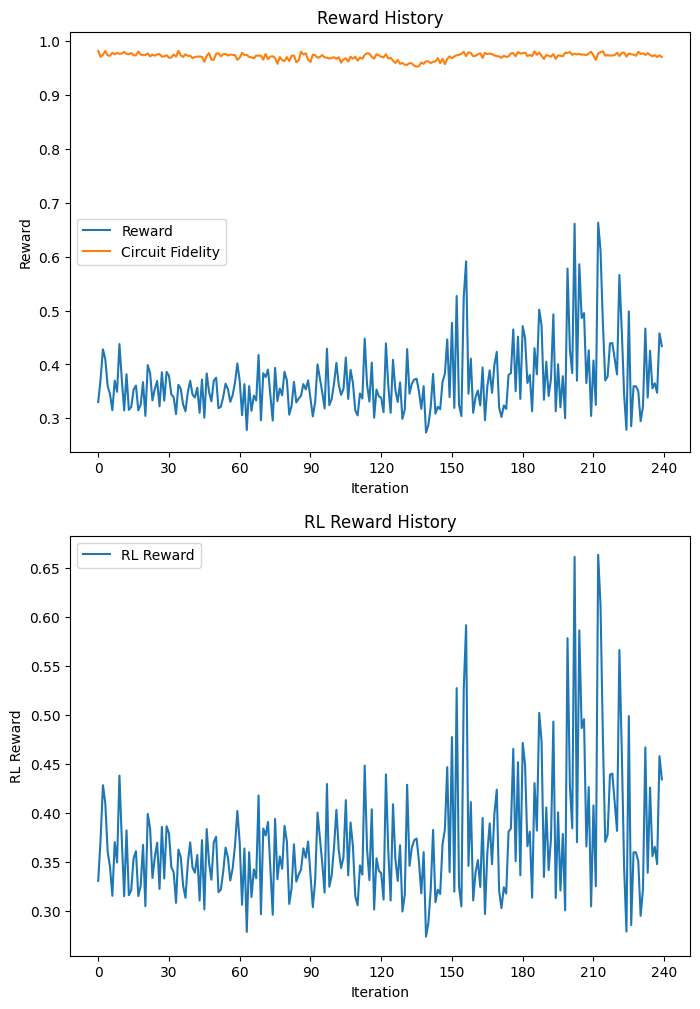

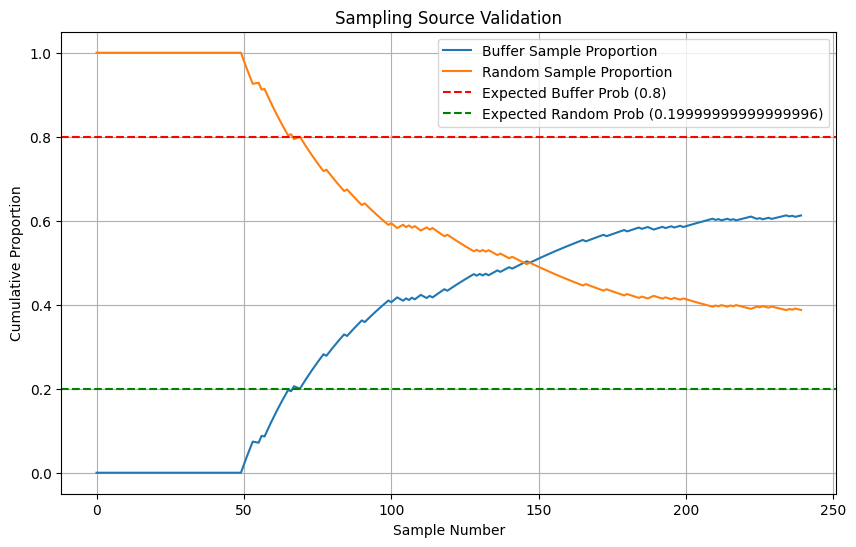

Buffer sample proportion: 0.613 (Expected: 0.8)
Random sample proportion: 0.387 (Expected: 0.19999999999999996)


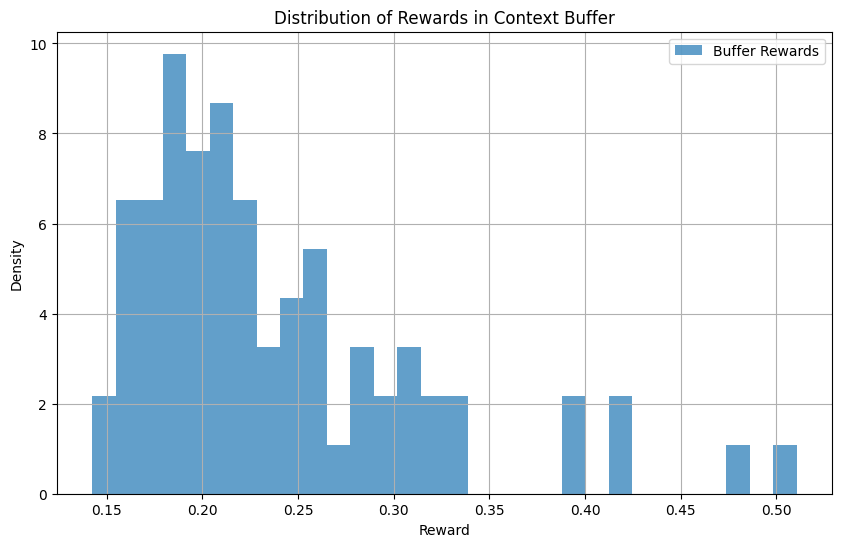

Buffer reward stats - Mean: 0.238, Std: 0.075


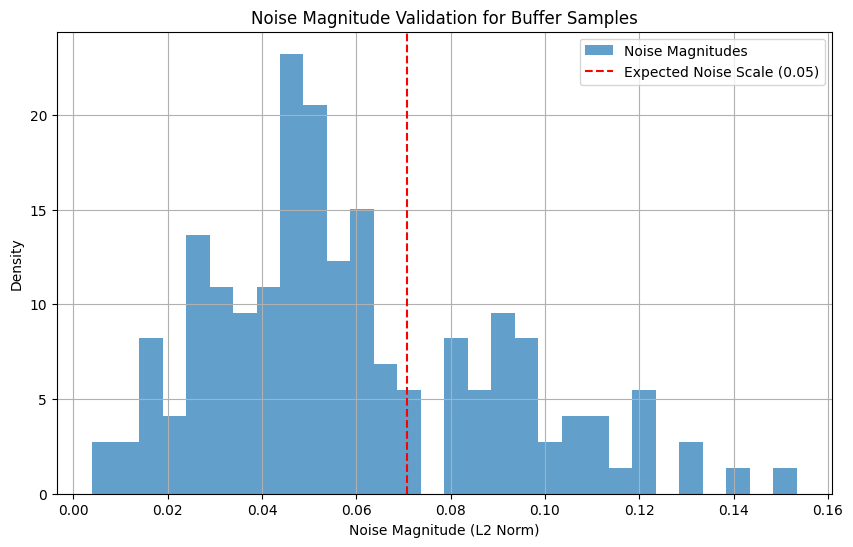

Mean noise magnitude: 0.059 (Expected ~0.071)


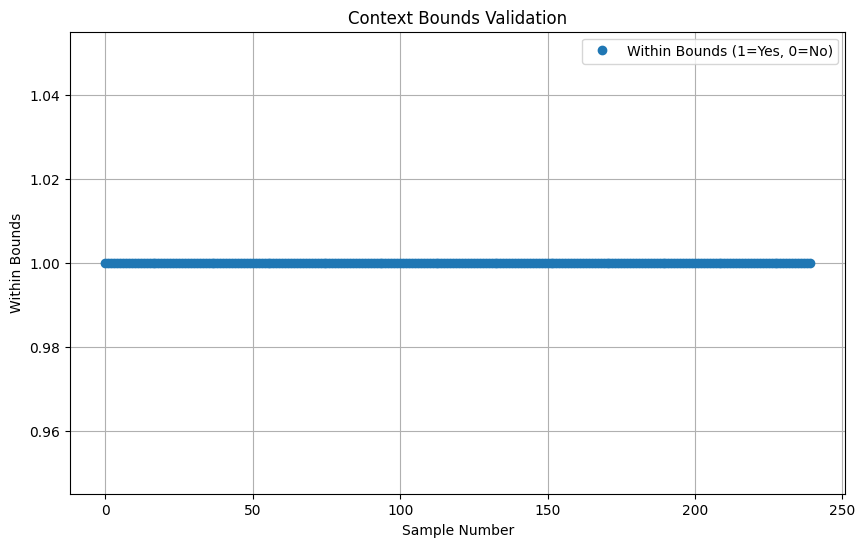

Proportion of contexts within bounds: 1.000
Sampled angles:  [ 0.          0.         -0.26522611  0.          0.41852953  0.        ]
Environment Observation: [-1.16884819 -0.73355582]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [136]:
ppo_agent.run_training()

In [121]:
NUM_EVAL = 25
import torch

action_list = []
obs_list = []
reward_list = []

for n in range(NUM_EVAL):
    obs, _ = ppo_agent.env.reset()
    obs_list.append(obs)
    batch_obs = np.tile(obs, (32, 1))
    with torch.no_grad():
        batch_action, logprob, _, value = ppo_agent.agent.get_action_and_value(
            torch.Tensor(batch_obs)
        )
    next_obs, reward, terminations, truncations, infos = ppo_agent.env.step(
        batch_action.numpy()
    )
    reward_list.append(np.mean(reward))
    mean_action = np.mean(batch_action.numpy(), axis=0)
    action_list.append(mean_action)

Sampled angles:  [0.         0.         2.96869153 0.         1.29664134 0.        ]
Environment Observation: [ 0.88992772 -0.17453248]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9848517149148289
Reward (avg): 0.7916680466162214 Std: 0.058155205484511356
obs: [ 0.88992772 -0.17453248]
reward: [0.81008839 0.57197292 0.78857876 0.65774251 0.73272009 0.53780372
 0.72168273 0.49717351 0.5899679  0.61390015 0.64125287 0.46430303
 0.88101515 0.74676451 0.57560908 0.6764244  0.50560031 0.88025553
 0.75380564 0.68906921 0.71599903 0.61842573 0.61188638 0.60678599
 0.85286361 0.91586277 0.87385327 0.86833034 0.78072841 0.73738234
 0.7102173  0.70986357]
Sampled angles:  [0.         0.         2.25298006 0.         0.78041497 0.        ]
Environment Observation: [ 0.43429166 -0.5031724 ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9945809850318181
Reward (avg): 0.880244451123098 Std: 0.08243964914950735
obs: [ 0.43429166 -0.5031724 ]
reward: [1.15725356 1.14868538 1.03361832 0.83313142 1.08191144 1.54176148
 2.0459936  1.43566243 0.73857205 0.84090358 1.17877572 2.81315083
 0.94717816 0.8596314  1.15235177 0.83368875 0.42359837 0.84658535
 0.85337555 0.62643892 1.04800954 1.04258645 0.48525397 1.64840185
 0.92578268 1.06841465 0.89184449 0.64321798 1.28850781 0.73055588
 1.0043058  0.95762996]
Sampled angles:  [0.         0.         1.06990185 0.         2.59119472 0.        ]
Environment Observation: [-0.31887933  0.6496058 ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9884027843276276
Reward (avg): 0.6820441400707241 Std: 0.2114349819312703
obs: [-0.31887933  0.6496058 ]
reward: [0.9566905  0.86154951 0.34996378 0.72866974 0.21499057 0.82179762
 0.82838485 0.7419061  0.47430895 1.0223968  0.81761802 0.19851498
 1.38086295 0.48747356 0.90941712 0.2760118  0.88470803 0.62383874
 0.17560435 0.42019104 0.75806102 0.14760907 0.498955   0.39525637
 0.20161347 0.81344182 0.54060146 0.44182805 0.17867182 0.90960582
 1.23346658 0.1740347 ]
Sampled angles:  [0.         0.         1.79841133 0.         0.98998857 0.        ]
Environment Observation: [ 0.14490421 -0.3697537 ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9948132602884323
Reward (avg): 0.886373063622099 Std: 0.13346445732711054
obs: [ 0.14490421 -0.3697537 ]
reward: [1.56767019 1.46639036 0.92551753 1.50801781 0.8065153  0.85854784
 0.29632902 1.54974034 1.87441465 1.34231349 1.83794818 1.17156804
 1.56971747 0.98662615 0.89233822 1.49916149 0.69107458 1.28758902
 1.05650897 1.40623566 0.2474487  1.04730794 1.04141941 1.59243251
 0.37480584 1.0923237  0.80612739 1.49112612 0.87948084 1.22554522
 1.37061326 1.06151718]
Sampled angles:  [0.         0.         2.21824538 0.         0.08578179 0.        ]
Environment Observation: [ 0.41217887 -0.94538961]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9961443108445824
Reward (avg): 0.9198732861610919 Std: 0.07627901803994082
obs: [ 0.41217887 -0.94538961]
reward: [1.14415027 1.24259146 1.59303154 1.54957524 1.43054659 0.82884747
 1.5038915  1.90790296 1.29377932 0.94010727 0.73572364 1.67938121
 1.23876624 1.17661476 1.2101653  1.44863249 1.59429784 0.48498696
 1.33738835 1.29115897 1.51247632 1.32527067 1.34497727 1.08517768
 1.0902131  0.77312418 0.91881874 1.72655576 1.28246034 1.16868884
 1.1745217  0.48280718]
Sampled angles:  [0.         0.         0.3565268  0.         1.43695553 0.        ]
Environment Observation: [-0.77302799 -0.0852057 ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9966134326674727
Reward (avg): 0.8593160582858093 Std: 0.17401032250089646
obs: [-0.77302799 -0.0852057 ]
reward: [0.7284016  1.32380442 1.17643912 1.77674702 0.92621614 1.33443457
 1.51943536 0.78650513 1.01478776 1.3521518  1.13160227 1.32435119
 1.36264033 1.08410192 1.56355163 0.81032388 1.47118796 1.17453517
 0.78455903 0.84553334 1.11471079 0.19753367 0.92051691 1.17874039
 0.86840913 1.47113584 0.82144197 0.10540743 0.8623605  1.36077972
 0.89683532 0.26928422]
Sampled angles:  [0.         0.         1.05050237 0.         1.77509861 0.        ]
Environment Observation: [-0.33122942  0.13006288]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9958211585124939
Reward (avg): 0.8581398044252264 Std: 0.15718400296892254
obs: [-0.33122942  0.13006288]
reward: [0.30478468 1.30461316 0.82982705 1.4284358  1.21132716 0.73259905
 1.28899422 0.59961758 1.92018239 0.92348117 1.11304996 1.43743056
 0.83298085 0.26296185 1.18868961 1.0841673  1.53647496 1.10419723
 0.99292588 0.17047359 1.02281448 0.695123   0.65929589 1.90881469
 1.56244205 1.61288079 1.25583832 1.103921   1.62607797 1.17528068
 0.6794701  0.55846834]
Sampled angles:  [0.         0.         0.55886445 0.         1.43189905 0.        ]
Environment Observation: [-0.64421584 -0.08842475]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9973448782644406
Reward (avg): 0.9019963259541945 Std: 0.12252431957911046
obs: [-0.64421584 -0.08842475]
reward: [1.65409647 1.34948794 1.15158928 1.68722475 1.02447125 1.12068695
 1.25310676 1.56160964 0.96412735 0.90315566 1.17050114 0.14317788
 1.55846419 0.94270486 1.26573803 1.25220381 0.86438065 0.71197992
 1.03072888 1.33638877 1.50005731 0.65963128 0.81170242 0.78575789
 1.5848171  1.2694904  1.72554012 1.34428138 1.01552558 1.19326554
 1.18707543 1.35322196]
Sampled angles:  [0.        0.        1.738265  0.        2.2488845 0.       ]
Environment Observation: [0.10661387 0.43168434]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9851128777347122
Reward (avg): 0.6711993756180816 Std: 0.1614831659279541
obs: [0.10661387 0.43168434]
reward: [0.78950301 0.69830401 0.78923513 0.36027819 0.261049   0.76645468
 0.58518254 0.61670429 0.25613686 0.21957744 0.24539069 0.2780751
 0.68976108 0.52972025 0.25935307 0.53908761 0.66243564 0.4583959
 0.73338272 0.65738673 0.75400585 0.37863749 0.783263   0.31667068
 0.96670278 0.26239833 0.50854383 0.25731321 0.61294036 0.99906748
 0.31698653 0.71710893]
Sampled angles:  [0.         0.         2.76821165 0.         0.06400264 0.        ]
Environment Observation: [ 0.76229827 -0.95925465]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9932520375206991
Reward (avg): 0.9194359648086872 Std: 0.039947098902747336
obs: [ 0.76229827 -0.95925465]
reward: [0.91431597 0.96581364 1.06217758 1.36941229 1.13420633 1.42311205
 0.73926597 0.94174228 1.19102669 1.24088911 1.65854591 1.09967936
 0.88034027 0.97474263 0.97074366 0.87451519 1.36181497 1.66749009
 0.9850445  1.06243831 1.43686705 0.88797619 2.70041405 1.29620752
 1.41489803 0.89439503 1.08142595 1.07507081 1.38332533 1.00716363
 1.12574081 1.05473668]
Sampled angles:  [0.         0.         1.86483034 0.         2.19930908 0.        ]
Environment Observation: [0.18718786 0.40012364]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9828363981651735
Reward (avg): 0.6685320357568021 Std: 0.15134952336334667
obs: [0.18718786 0.40012364]
reward: [0.82415558 0.2524606  0.28879217 0.35498795 0.28549041 0.68010966
 0.42475243 0.58311394 0.32057801 0.62736763 0.26726067 0.4051245
 0.30277157 0.63782974 0.31681165 0.63132886 0.98019423 0.33256852
 0.37175355 1.27454244 0.8841501  0.75472141 0.5189156  0.48631469
 0.68573677 1.14120187 0.33388001 0.33391635 0.42334709 0.79670623
 0.56212446 0.31326308]
Sampled angles:  [0.         0.         2.70607348 0.         1.63733626 0.        ]
Environment Observation: [0.72273988 0.04236063]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9830233061626822
Reward (avg): 0.7423500852520906 Std: 0.06123418275372945
obs: [0.72273988 0.04236063]
reward: [0.67554598 0.66808266 0.49577487 0.57694898 0.50797499 0.77301929
 0.4358627  0.63492627 0.50863269 0.42119614 0.75057265 0.50508154
 0.67455346 0.55820382 0.70104706 0.53823423 0.59500411 0.65675512
 0.40276841 0.74731189 0.66614868 0.65662607 0.53096479 0.62092568
 0.70872913 0.67595544 0.61333843 0.47297346 0.62085319 0.69985048
 0.47422831 0.65541681]
Sampled angles:  [0.         0.         2.74371495 0.         2.72760873 0.        ]
Environment Observation: [0.74670319 0.73644965]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9938795963912501
Reward (avg): 0.6037473093337681 Std: 0.09161030015802327
obs: [0.74670319 0.73644965]
reward: [0.54037878 0.40876209 0.35487959 0.36613932 0.34549528 0.45840647
 0.33880876 0.32436382 0.34965257 0.28423013 0.39186798 0.6228897
 0.41987583 0.29799089 0.2886547  0.45068558 0.3542757  0.39723177
 0.68650107 0.50983857 0.32861131 0.40862667 0.35304503 0.47798586
 0.490061   0.65282831 0.37492769 0.31505679 0.25379606 0.39066814
 0.36901112 0.70402637]
Sampled angles:  [0.         0.         0.72058097 0.         2.46255784 0.        ]
Environment Observation: [-0.54126391  0.56771301]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9881833233441901
Reward (avg): 0.676390313319853 Std: 0.2623812889133649
obs: [-0.54126391  0.56771301]
reward: [0.33598379 0.90434752 0.17243017 1.39342007 0.7117411  0.9789388
 1.04176435 0.14203426 0.44361264 0.12759901 1.09409812 0.72387853
 0.16048887 0.19624936 1.29413248 0.96124076 0.89100709 1.21825317
 0.72706252 0.17648873 0.14026088 0.84515875 0.14100187 0.21334129
 0.63584436 0.1427779  0.77822561 0.83494455 1.37802835 0.61422399
 1.0567813  0.69347425]
Sampled angles:  [0.         0.         3.00904412 0.         2.86757547 0.        ]
Environment Observation: [0.91561699 0.82555524]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9927384868809028
Reward (avg): 0.5513257911230882 Std: 0.11907771995890583
obs: [0.91561699 0.82555524]
reward: [0.53236939 0.19965901 0.22322421 0.46284418 0.29213445 0.34823537
 0.5107498  0.36526478 0.51050935 0.42686451 0.33770387 0.41238956
 0.23250554 0.31391996 0.3204844  0.35418742 0.29608521 0.2334862
 0.19207355 0.28867881 0.42300013 0.4482072  0.50061127 0.16971966
 0.62570181 0.28660843 0.49100644 0.29773505 0.40994689 0.56439757
 0.19096767 0.38561207]
Sampled angles:  [0.         0.         2.68124109 0.         2.03493609 0.        ]
Environment Observation: [0.70693109 0.29548055]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9878221171394742
Reward (avg): 0.7140029163039748 Std: 0.08131074595670731
obs: [0.70693109 0.29548055]
reward: [0.51334529 0.45458951 0.52520989 0.44692693 0.57273492 0.57603959
 0.46385068 0.57697337 0.84611895 0.53751982 0.80265756 0.7380233
 0.67823142 0.39972846 0.46459059 0.58662965 0.37357031 0.73059529
 0.5177347  0.57634751 0.76639184 0.33104684 0.44655501 0.5418613
 0.34167082 0.54482655 0.64888823 0.65241465 0.52289251 0.49074869
 0.64375542 0.66648141]
Sampled angles:  [0.         0.         1.08939972 0.         0.45523298 0.        ]
Environment Observation: [-0.3064666  -0.71018968]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9985564809784637
Reward (avg): 0.943920802489139 Std: 0.03983824937844567
obs: [-0.3064666  -0.71018968]
reward: [1.56484424 1.11178469 1.88437588 1.14835481 1.15211101 2.1405678
 2.00331946 1.0805714  1.43395522 1.5805122  1.07980593 1.25267118
 1.78310891 0.76501703 1.05354897 1.06541019 1.565265   1.56366976
 1.15717958 1.05328933 0.80632216 1.1751915  0.95397616 1.71268896
 1.27775196 1.4912552  1.39418775 1.22665934 1.86147893 1.52305303
 1.17400282 2.05933184]
Sampled angles:  [0.         0.         0.24576693 0.         2.19639955 0.        ]
Environment Observation: [-0.84353992  0.39827138]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9950302049513642
Reward (avg): 0.7628922531276101 Std: 0.21224269979914712
obs: [-0.84353992  0.39827138]
reward: [0.64787619 0.76146218 1.01475158 1.02492    0.27001227 1.15848599
 0.17097065 0.74532165 0.4079185  0.6614179  0.82697221 1.0746799
 0.72162647 1.01771416 1.04867066 0.41444619 0.19653225 0.90659092
 0.36963073 1.16808508 0.1408057  1.21290362 0.92695147 1.21000429
 0.9742701  0.10404623 0.54984952 0.90726275 1.26767701 0.86738588
 0.7713811  1.23646441]
Sampled angles:  [0.         0.         3.13763617 0.         1.00697563 0.        ]
Environment Observation: [ 0.99748123 -0.3589394 ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9833220260448886
Reward (avg): 0.7922664398490824 Std: 0.07876721911969549
obs: [ 0.99748123 -0.3589394 ]
reward: [0.94727368 0.70564068 0.83215809 0.64472503 0.50702792 0.85831328
 0.64995952 0.81146873 0.44886651 0.85914069 1.06329345 0.51808001
 0.53696097 0.82049392 0.77541188 0.45015968 0.62893302 0.5202165
 0.86383594 0.89302578 0.662587   0.56886943 0.93092608 0.76584934
 0.67274016 1.32017938 0.54495037 0.81099731 0.5818185  0.56167701
 0.54166698 0.7285303 ]
Sampled angles:  [0.         0.         1.28555851 0.         2.37927009 0.        ]
Environment Observation: [-0.18158803  0.51469038]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9879325455520886
Reward (avg): 0.6849433714109214 Std: 0.1908598305321683
obs: [-0.18158803  0.51469038]
reward: [0.73740878 0.20027595 0.69996485 0.19487626 0.1983012  1.10384666
 0.40505997 0.76365498 0.63548013 0.76447991 0.63413706 1.41586397
 0.18495028 0.64670466 0.31946266 0.75962686 0.80607569 0.43520026
 0.47856731 0.68036342 0.26192227 0.67123133 1.07956034 0.334331
 0.35635105 0.86375764 0.67182693 0.2258296  0.20480966 0.5827537
 0.86665324 0.77107581]
Sampled angles:  [0.         0.         2.72247935 0.         0.72198614 0.        ]
Environment Observation: [ 0.73318419 -0.54036935]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9830238087363012
Reward (avg): 0.8664504642989521 Std: 0.05006368623611418
obs: [ 0.73318419 -0.54036935]
reward: [0.69434092 0.94999543 0.82079474 0.9138963  1.0344178  1.02230117
 1.08515492 0.75919155 0.74416987 0.76483232 0.73766367 0.74379859
 0.84405923 1.20907901 1.03629927 0.8888993  0.71227492 0.97008349
 0.72914373 0.99289591 1.48895439 0.78848481 0.87142118 0.7042355
 0.58480269 1.02177036 0.99651456 1.22074085 0.88444064 0.93399669
 0.82192592 1.15078305]
Sampled angles:  [0.         0.         1.03138111 0.         2.62806173 0.        ]
Environment Observation: [-0.3434024   0.67307606]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9843938139266226
Reward (avg): 0.6175799392892755 Std: 0.24798615145009623
obs: [-0.3434024   0.67307606]
reward: [0.1440483  0.75675911 1.1174514  1.21600775 0.20394018 0.2609283
 0.18083479 1.01139109 1.16065747 0.54147287 0.19095604 1.07458855
 0.18073231 0.83757995 0.21039954 0.17698694 0.93230512 0.23391138
 0.6265139  0.17832809 0.7376573  0.71564065 0.19871944 0.81973202
 0.8418597  0.14857734 0.70063332 0.72549862 0.15816164 0.16314024
 0.36901525 0.5295357 ]
Sampled angles:  [0.         0.         0.62468043 0.         1.9753061  0.        ]
Environment Observation: [-0.60231609  0.25751892]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9964857065481407
Reward (avg): 0.8677078546754584 Std: 0.16224511826634178
obs: [-0.60231609  0.25751892]
reward: [1.0479882  0.2953722  1.45263251 1.65364206 1.20995837 1.31551947
 1.54509191 1.1480242  1.5215273  1.00184776 0.87268388 1.84567617
 0.7565943  1.3354221  0.85567097 1.1200137  0.98199459 0.98633375
 1.38154162 0.95422059 1.28044889 0.53452777 1.60533184 1.19568586
 0.90070039 2.10281521 1.26222605 1.03301983 0.84935143 0.1265083
 0.77201379 0.28093475]
Sampled angles:  [0.         0.         3.06302162 0.         1.13811413 0.        ]
Environment Observation: [ 0.94998013 -0.27545404]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9847263936761059
Reward (avg): 0.8139986461779678 Std: 0.08219744363879863
obs: [ 0.94998013 -0.27545404]
reward: [0.83264261 0.55177842 0.64358187 0.73841961 0.94705517 0.5604606
 1.21894476 0.78441239 0.52372524 0.68122241 0.78146501 1.14047955
 0.59037682 0.84694407 0.46515255 0.73479637 0.85998067 0.66478227
 0.70056604 0.93210962 0.52623961 0.67201732 1.06004274 1.10270273
 1.09990688 0.69117188 0.60409518 0.94449564 0.41692843 0.93243818
 0.62887349 0.9875722 ]
Sampled angles:  [0.         0.         0.21552324 0.         1.25445532 0.        ]
Environment Observation: [-0.86279364 -0.20138894]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9978228505688898
Reward (avg): 0.8895764903831092 Std: 0.1291519167463318
obs: [-0.86279364 -0.20138894]
reward: [1.34109291 0.99349703 0.94178345 0.97253933 1.03249035 1.08987377
 0.77625142 1.14206196 2.17279052 0.11305006 1.95060735 0.89424222
 1.95771461 1.04817006 1.45328128 1.35464752 0.98484892 1.61914468
 0.89890907 1.10754532 0.78938423 0.82850818 0.83052808 0.8795402
 0.76171917 0.76363352 1.50445682 0.80114965 1.20585523 1.3031464
 1.30082195 1.43739696]


/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_24459/4258992135.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


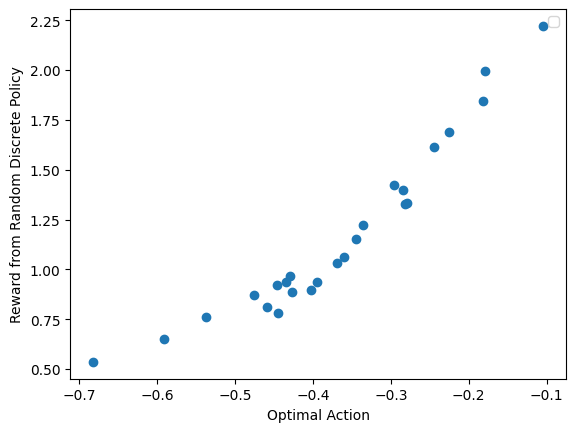

In [107]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[2, 4], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1) / 0.2

plt.scatter(optimal_action, reward_list)
plt.xlabel('Optimal Action')
plt.ylabel('Reward from Random Discrete Policy')
plt.legend()
plt.show()

In [108]:
context_history = ppo_agent.context_history
context_buffer = ppo_agent.context_buffer
context_rewards = ppo_agent.context_rewards

print(len(context_history))
print(len(context_buffer))
print(len(context_rewards))

390
75
75


In [109]:
context_buffer

[array([-0.67629373, -0.39846514]),
 array([0.30906885, 0.14189708]),
 array([0.05002447, 0.00833782]),
 array([ 0.28713505, -0.15157858]),
 array([0.07466596, 0.71755167]),
 array([-0.38677141, -0.76543814]),
 array([-0.21937264,  0.79855824]),
 array([0.01340053, 0.56936887]),
 array([0.56572381, 0.79092146]),
 array([0.5191694 , 0.87141434]),
 array([0.56695938, 0.29463432]),
 array([-0.45329238,  0.65258348]),
 array([-0.11293255,  0.54044527]),
 array([ 0.49586666, -0.81664931]),
 array([-0.21501265,  0.50940289]),
 array([-0.42880842, -0.78781726]),
 array([-0.55615714,  0.48774977]),
 array([-0.7459613, -0.4437517]),
 array([0.88440788, 0.73563308]),
 array([ 0.37218875, -0.71993729]),
 array([-0.46623401,  0.69936023]),
 array([0.53647161, 0.69454089]),
 array([0.00184628, 0.7281527 ]),
 array([-0.27541888,  0.8816363 ]),
 array([ 0.39249618, -0.94940283]),
 array([0.81645765, 0.57055168]),
 array([-0.19441062,  0.4501874 ]),
 array([-0.08624406,  0.35296766]),
 array([0.437443

In [110]:
context_rewards

[1.798170051315672,
 2.0475941813835745,
 1.9899401390717002,
 2.176514332580041,
 1.8796656851104787,
 1.6728780892246924,
 1.9555176498407656,
 1.8954652854763334,
 1.8286279378777546,
 1.9851194414375777,
 2.2843030829463538,
 1.968687598961069,
 1.9798956200452948,
 1.7331089411862397,
 1.9665740436759926,
 1.4642050187323457,
 2.0468910192067162,
 1.6481667812102647,
 1.6268288805978068,
 2.0112044689808073,
 2.1612196936761565,
 1.7357855211561422,
 2.073063243622899,
 2.139228604964728,
 1.9358839733658746,
 1.8692386906077214,
 2.0845303778891155,
 2.124719866489396,
 1.8215481546796708,
 1.9879571087798555,
 1.5547532017640133,
 2.1007541172852706,
 2.157463976174562,
 2.0687962548296883,
 2.105551559768551,
 2.328765539010689,
 2.3482321371181483,
 1.8376542584397497,
 1.7476036867179348,
 2.085879033641997,
 1.5710040103127585,
 2.168033415217281,
 2.1734056035582228,
 1.7559030402017841,
 2.233029033897607,
 1.8763501271358152,
 1.9292702726170947,
 2.031582616707416,
 2.12

In [111]:
context_history

[(1, array([-0.16595599,  0.44064899])),
 (2, array([0.96351328, 0.78604242])),
 (3, array([ 0.58074705, -0.56500156])),
 (4, array([ 0.04559206, -0.67612421])),
 (5, array([0.96151755, 0.37312636])),
 (6, array([-0.9340784 , -0.03580477])),
 (7, array([-0.22799198,  0.14308419])),
 (8, array([ 0.80820597, -0.53246261])),
 (9, array([-0.43251292, -0.1631756 ])),
 (10, array([ 0.66735206, -0.28751959])),
 (11, array([-0.72083449, -0.35276557])),
 (12, array([ 0.44816969, -0.07640118])),
 (13, array([-0.31770635, -0.91137669])),
 (14, array([ 0.32003045, -0.00752772])),
 (15, array([0.14687074, 0.08726951])),
 (16, array([0.59499197, 0.57283416])),
 (17, array([ 0.89126857, -0.23217152])),
 (18, array([-0.35591267,  0.91383243])),
 (19, array([-0.37014196, -0.26628136])),
 (20, array([0.03737962, 0.8171025 ])),
 (21, array([0.39937671, 0.83864479])),
 (22, array([0.52085953, 0.4238788 ])),
 (23, array([ 0.70100699, -0.78080279])),
 (24, array([ 0.29629744, -0.80498846])),
 (25, array([ 0

In [112]:
context_history_arr = np.array([j for (i, j) in context_history])
context_history_arr.shape

(390, 2)

In [113]:
context_history_arr

array([[-0.16595599,  0.44064899],
       [ 0.96351328,  0.78604242],
       [ 0.58074705, -0.56500156],
       [ 0.04559206, -0.67612421],
       [ 0.96151755,  0.37312636],
       [-0.9340784 , -0.03580477],
       [-0.22799198,  0.14308419],
       [ 0.80820597, -0.53246261],
       [-0.43251292, -0.1631756 ],
       [ 0.66735206, -0.28751959],
       [-0.72083449, -0.35276557],
       [ 0.44816969, -0.07640118],
       [-0.31770635, -0.91137669],
       [ 0.32003045, -0.00752772],
       [ 0.14687074,  0.08726951],
       [ 0.59499197,  0.57283416],
       [ 0.89126857, -0.23217152],
       [-0.35591267,  0.91383243],
       [-0.37014196, -0.26628136],
       [ 0.03737962,  0.8171025 ],
       [ 0.39937671,  0.83864479],
       [ 0.52085953,  0.4238788 ],
       [ 0.70100699, -0.78080279],
       [ 0.29629744, -0.80498846],
       [ 0.47043111, -0.95601498],
       [-0.42901082, -0.98640911],
       [-0.47896107, -0.42915801],
       [ 0.88419332,  0.33998981],
       [-0.37122758,

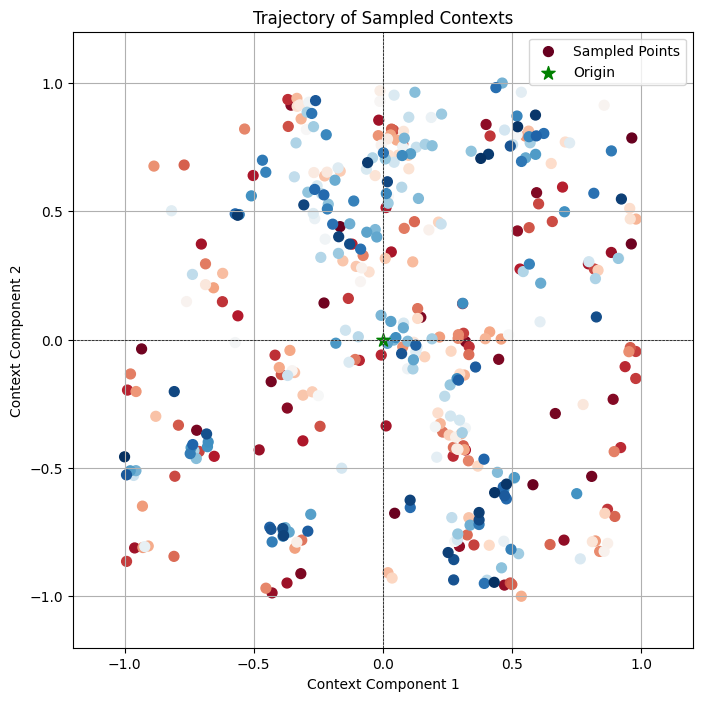

In [114]:
context_buffer_arr = np.array(context_buffer)
context_buffer_arr.shape

def plot_trajectory(context_history, filename='context_trajectory.png'):
    """Plot the trajectory of sampled contexts with color-coded time evolution."""
    plt.figure(figsize=(8, 8))
    # plt.plot(context_history[:, 0], context_history[:, 1], 'b-', alpha=0.5, label='Trajectory')
    # Create a color map from red (early) to blue (late)
    colors = plt.cm.RdBu(np.linspace(0, 1, len(context_history)))
    plt.scatter(context_history[:, 0], context_history[:, 1], c=colors, s=50, label='Sampled Points')
    plt.scatter(0, 0, c='green', s=100, marker='*', label='Origin')
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.title('Trajectory of Sampled Contexts')
    plt.xlabel('Context Component 1')
    plt.ylabel('Context Component 2')
    plt.legend()
    plt.grid(True)
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    # plt.savefig(filename)
    plt.show()

plot_trajectory(context_history_arr)

# plt.scatter(context_buffer_arr[:,0], context_buffer_arr[:,1], label='most recent context buffer')
# plt.scatter(context_history_arr[:,0], context_history_arr[:,1], label='context history')
# plt.legend()
# plt.show()

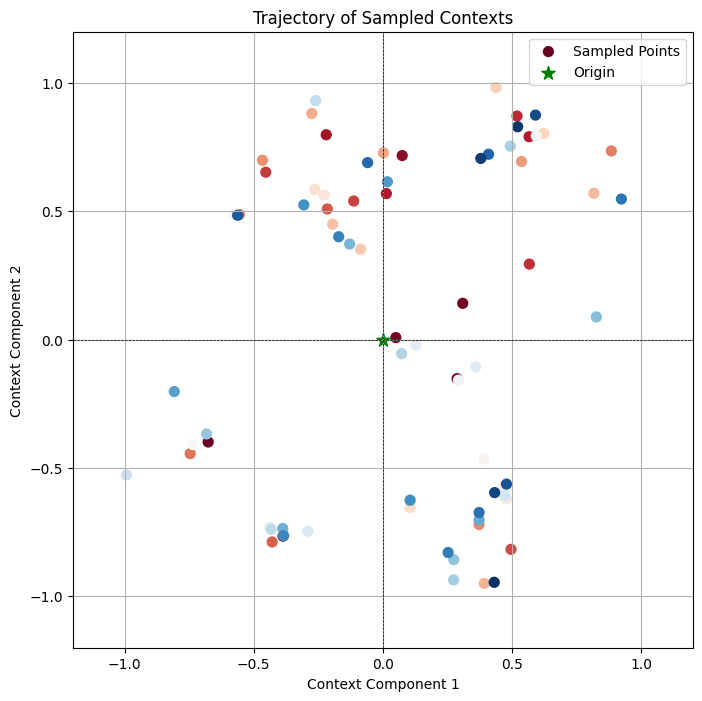

In [115]:
plot_trajectory(context_buffer_arr)

In [116]:
phi_spillover = np.sum((0.5 * (context_buffer_arr + 1.) * np.pi * 0.025), axis=1)
phi_spillover

array([0.03633413, 0.09624921, 0.0808317 , 0.08386311, 0.10965013,
       0.03329265, 0.10128438, 0.10142512, 0.13181515, 0.13314791,
       0.11237452, 0.08636596, 0.0953282 , 0.06594271, 0.09010049,
       0.03076304, 0.07585347, 0.0318199 , 0.14215868, 0.06488376,
       0.08769466, 0.12688156, 0.10720681, 0.10234592, 0.05667014,
       0.13300755, 0.08858415, 0.08901403, 0.13428627, 0.13455923,
       0.05701913, 0.0911674 , 0.09172806, 0.07295552, 0.07431599,
       0.07534895, 0.07562446, 0.03359279, 0.13305279, 0.0838556 ,
       0.03265073, 0.08270718, 0.08844161, 0.03783466, 0.07317017,
       0.01888554, 0.10488774, 0.03252564, 0.07925733, 0.12753342,
       0.05254302, 0.0373216 , 0.05567031, 0.11446839, 0.08812356,
       0.03442932, 0.06559057, 0.03889077, 0.10338967, 0.08714471,
       0.05812651, 0.03347   , 0.08757749, 0.05589459, 0.1363203 ,
       0.06672351, 0.103314  , 0.12296689, 0.07549637, 0.07523343,
       0.13610659, 0.07213187, 0.12116009, 0.13160963, 0.05834

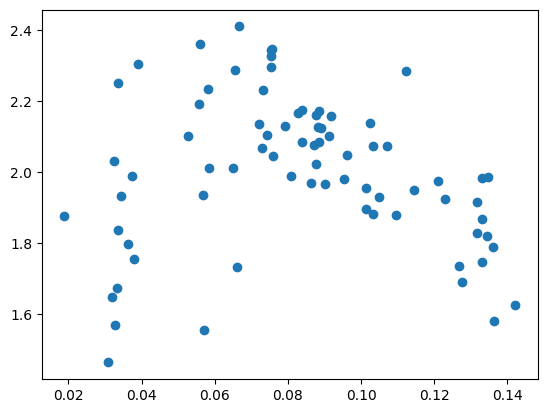

In [117]:
plt.scatter(phi_spillover, context_rewards)
plt.show()

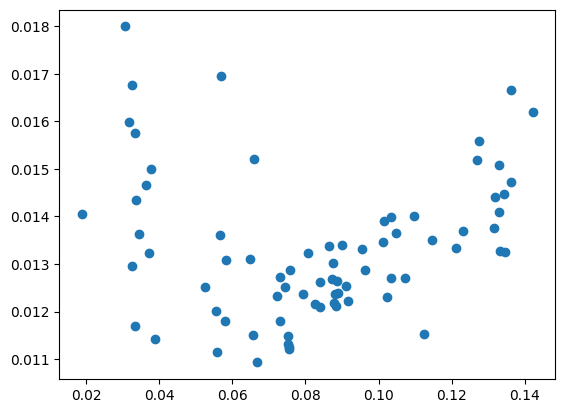

In [118]:
prob_weights = 1/np.array(context_rewards)
prob_weights /= np.sum(prob_weights)

plt.scatter(phi_spillover, prob_weights)
plt.show()

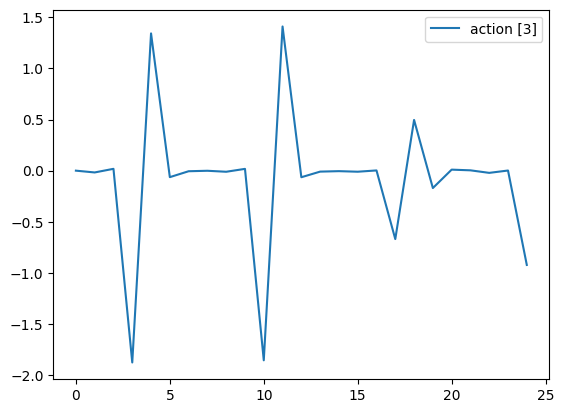

In [55]:
action_arr = np.array(action_list)
action_arr = action_arr.reshape(7, -1)

for i in range(len(action_arr)):
    if i == 3:
        plt.plot(action_arr[i], label=f'action [{i}]')
plt.legend()
plt.show()

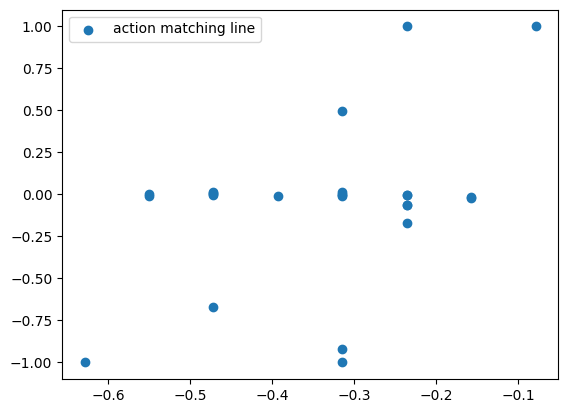

In [56]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[2, 4], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1) / 0.25

action_relevant = action_arr[3]

plt.scatter(optimal_action, np.clip(action_relevant, a_min=-1., a_max=1.), label='action matching line')
plt.legend()
plt.show()

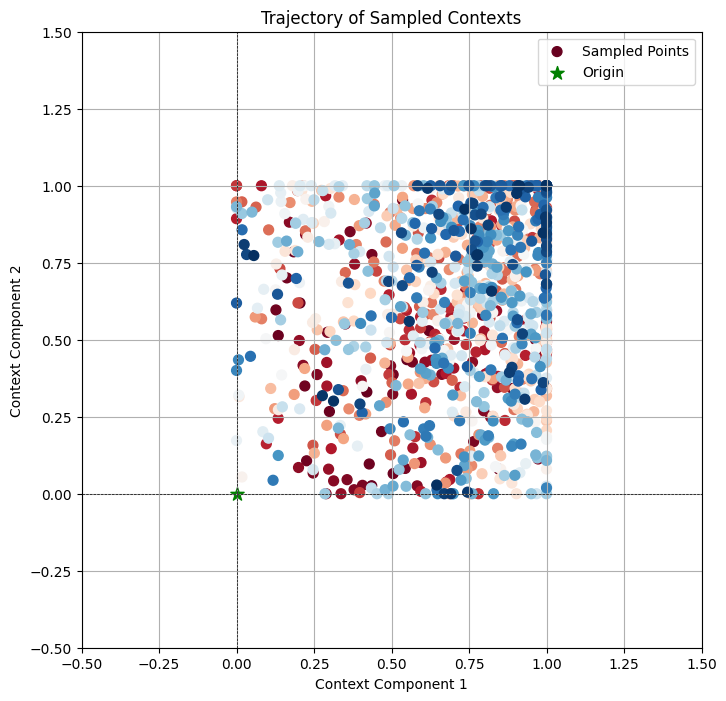

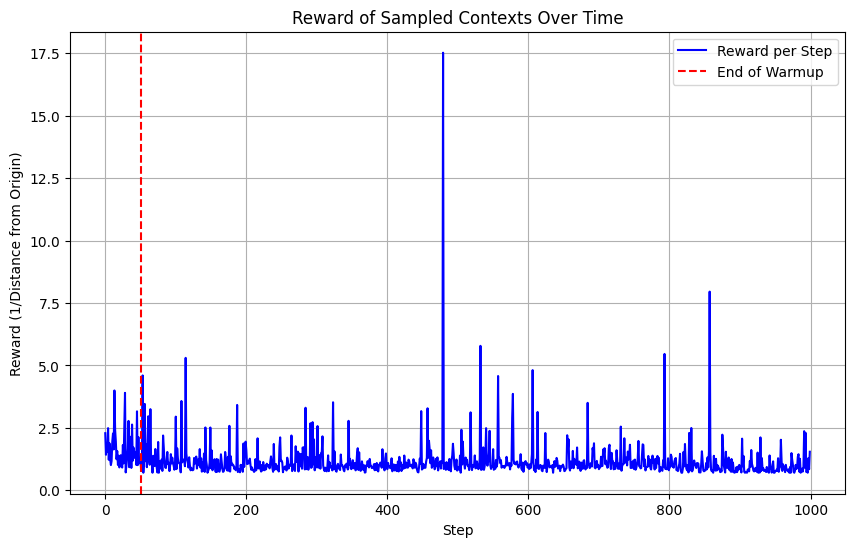

Mean reward: 1.1824
Std reward: 0.7936
Min reward: 0.7071
Max reward: 17.5196


In [83]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Initialize parameters
BUFFER_SIZE = 50
WARMUP_STEPS = 50
TOTAL_STEPS = 1000  # Total simulation steps (including warmup)
SAMPLING_PROB = 0.9  # Probability of sampling from buffer (vs random)
NOISE_SCALE = 0.1  # Scale of random noise for buffer sampling
np.random.seed(2)  # For reproducibility

# Buffer to store (context, reward) tuples
buffer = []

def calculate_reward(context):
    """Calculate reward as 1/distance, capped to avoid infinity at origin."""
    distance = np.sqrt(context[0]**2 + context[1]**2)
    # Cap reward at 100 to handle near-origin cases
    return min(1 / (distance + 1e-6), 100)

def sample_random_context():
    """Sample a random context with each component in [0, 1]."""
    return np.random.uniform(0, 1, size=2)

def sample_context_from_buffer():
    """Sample a context from buffer with probability proportional to inverse reward, add noise."""
    if not buffer:
        return sample_random_context()
    
    # Extract rewards
    rewards = np.array([reward for _, reward in buffer])
    # Calculate inverse rewards (lower reward -> higher probability)
    inverse_rewards = 1 / (rewards + 1e-6)
    # Normalize to get probabilities
    probabilities = inverse_rewards / np.sum(inverse_rewards)
    # Sample index based on probabilities
    index = np.random.choice(len(buffer), p=probabilities)
    # Get the context
    context, _ = buffer[index]
    # Add Gaussian noise with scale 0.05
    noisy_context = context + np.random.normal(0, NOISE_SCALE, size=2)
    # Clip to ensure context stays in [0, 1]
    noisy_context = np.clip(noisy_context, 0, 1)
    return noisy_context

def run_simulation():
    """Run the simulation and return history of sampled contexts."""
    context_history = []
    
    # Warmup phase
    for _ in range(WARMUP_STEPS):
        context = sample_random_context()
        reward = calculate_reward(context)
        buffer.append((context, reward))
        context_history.append(context)
    
    # Main simulation phase
    for _ in range(TOTAL_STEPS - WARMUP_STEPS):
        # With probability SAMPLING_PROB, sample from buffer; otherwise, sample randomly
        if np.random.random() < SAMPLING_PROB:
            context = sample_context_from_buffer()
        else:
            context = sample_random_context()
        reward = calculate_reward(context)
        # If buffer is at max size, remove context with highest reward
        if len(buffer) >= BUFFER_SIZE:
            # Find index of context with highest reward
            max_reward_idx = 0 # np.argmax([r for _, r in buffer])
            buffer.pop(max_reward_idx)
        # Add new context and reward
        buffer.append((context, reward))
        context_history.append(context)
    
    return np.array(context_history)

def plot_trajectory(context_history, filename='context_trajectory.png'):
    """Plot the trajectory of sampled contexts with color-coded time evolution."""
    plt.figure(figsize=(8, 8))
    # plt.plot(context_history[:, 0], context_history[:, 1], 'b-', alpha=0.5, label='Trajectory')
    # Create a color map from red (early) to blue (late)
    colors = plt.cm.RdBu(np.linspace(0, 1, len(context_history)))
    plt.scatter(context_history[:, 0], context_history[:, 1], c=colors, s=50, label='Sampled Points')
    plt.scatter(0, 0, c='green', s=100, marker='*', label='Origin')
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.title('Trajectory of Sampled Contexts')
    plt.xlabel('Context Component 1')
    plt.ylabel('Context Component 2')
    plt.legend()
    plt.grid(True)
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    # plt.savefig(filename)
    plt.show()

def plot_reward_distribution(context_history, filename='reward_distribution.png'):
    """Plot the distribution of rewards over time."""
    rewards = np.array([calculate_reward(context) for context in context_history])
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, 'b-', label='Reward per Step')
    plt.axvline(WARMUP_STEPS, color='red', linestyle='--', label='End of Warmup')
    plt.title('Reward of Sampled Contexts Over Time')
    plt.xlabel('Step')
    plt.ylabel('Reward (1/Distance from Origin)')
    plt.legend()
    plt.grid(True)
    # plt.savefig(filename)
    plt.show()

# Run simulation and generate plots
context_history = run_simulation()
plot_trajectory(context_history)
plot_reward_distribution(context_history)

# Print some basic statistics
rewards = np.array([calculate_reward(context) for context in context_history])
print(f"Mean reward: {np.mean(rewards):.4f}")
print(f"Std reward: {np.std(rewards):.4f}")
print(f"Min reward: {np.min(rewards):.4f}")
print(f"Max reward: {np.max(rewards):.4f}")

In [84]:
contexts = [c for c, r in buffer]

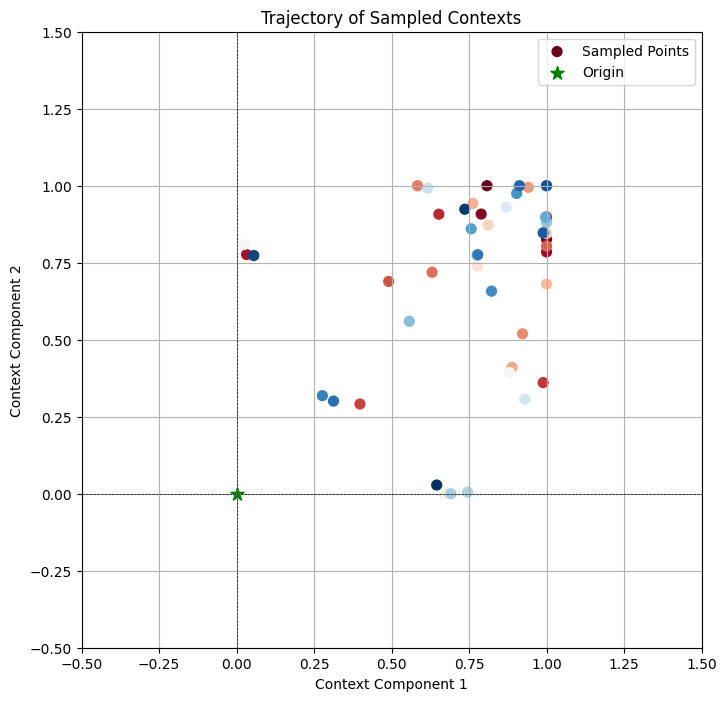

In [85]:
contexts_arr = np.array(contexts)

plot_trajectory(contexts_arr)

In [172]:
li = [1, 2, 3]
li.append(4)
li.pop(0)
li

[2, 3, 4]